# Requisitos para Replicar Este Notebook


En esta sección, se describen los elementos necesarios para replicar este notebook, incluyendo:

- **Rutas de los archivos requeridos**: Las ubicaciones de los archivos necesarios para la ejecución.
- **Bibliotecas necesarias**: Las dependencias que deben instalarse para utilizar el notebook.
- **Modo de ejecución del notebook**: Este comportamiento está controlado por la variable `saltarse_generacion_modelos`:
  - **`True`**: Se omite la generación de nuevos modelos y se cargan los modelos previamente generados desde la carpeta `modelos`.
  - **`False`**: Se generan nuevos modelos, que serán guardados en la carpeta `modelos`.

Finalmente, se establece una semilla para garantizar la reproducibilidad de los resultados obtenidos.

## Rutas directorio de los archivos

Definimos todas las rutas que usaremos en este notebook.

- `ruta_modelos_adaboost`: Ruta donde se guardarán los modeelos de AdaBoost.
- `ruta_modelos_rf`: Ruta donde se guardarán los modelos de Random Forest.
- `ruta_modelos_stacking`: Ruta donde se guardarán los modelos de Stacking.
- `ruta_modelos_arbol`: Ruta donde se guardarán los modelos de Arbol de Decisión.
- `ruta_modelos_knn`: Ruta donde se guardarán los modelos de knn.
- `ruta_lectura_dataset`: Ruta donde se encuentra el archivo `TarjetaCredito.csv`.

In [1]:
import os


ruta_modelos_adaboost = './modelos/adaboost/'
ruta_modelos_rf = './modelos/randomforest/'
ruta_modelos_stacking = './modelos/stacking/'
ruta_modelos_arbol = './modelos/arbol/'
ruta_modelos_knn = './modelos/knn/'

ruta_lectura_dataset = './data/'

os.makedirs(ruta_modelos_adaboost, exist_ok=True)
os.makedirs(ruta_modelos_rf, exist_ok=True)
os.makedirs(ruta_modelos_stacking, exist_ok=True)
os.makedirs(ruta_modelos_arbol, exist_ok=True)
os.makedirs(ruta_modelos_knn, exist_ok=True)


## Importación de librerias

Importamos todas las librerías necesarias para la ejecución de este notebook

In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from IPython.core.magic import register_cell_magic
import IPython

# Scikit-learn: preprocesamiento, modelos, métricas, y utilidades
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay,
    make_scorer, 
    precision_score, 
    recall_score, 
    f1_score
)

# Visualización de métricas
import seaborn as sns
import matplotlib.pyplot as plt

# Guardar y cargar modelos
import joblib


Imprimimos todas las versiones de las librerías que estamos usando.

In [3]:
# Versión de python
print(f"Versión de Python: {sys.version.split()[0]}")

# Versión de pandas
print(f"Versión de pandas: {pd.__version__}")

# Versión de numpy
print(f"Versión de numpy: {np.__version__}")

# Versión de seaborn
print(f"Versión de seaborn: {sns.__version__}")

# Versión de matplotlib
print(f"Versión de matplotlib: {plt.matplotlib.__version__}")

# Versión de scikit-learn
print(f"Versión de scikit-learn: {joblib.__version__}")

# Versión de joblib
print(f"Versión de joblib: {joblib.__version__}")

# Versión de scipy
print(f"Versión de scipy: {scipy.__version__}")

# Versión de IPython
print(f"Versión de IPython: {IPython.__version__}")



Versión de Python: 3.10.15
Versión de pandas: 2.2.2
Versión de numpy: 1.26.4
Versión de seaborn: 0.13.2
Versión de matplotlib: 3.9.2
Versión de scikit-learn: 1.4.2
Versión de joblib: 1.4.2
Versión de scipy: 1.13.1
Versión de IPython: 8.29.0


## Modo de ejecución del notebook

Dependiendo del modo de ejecución del notebook, se ejecutarán todas las celdas o todas las celdas excepto las que contienen la creación de los modelos.
Por defecto, la variable `saltarse_generacion_modelos` está establecida en `True`, por lo que se omitirá la generación de los modelos.

In [4]:
saltarse_generacion_modelos = True

Esta es la función que nos ayudará a poder ejecutar el notebook en modo de generación de modelos o en modo de carga de modelos.

In [5]:
@register_cell_magic
def skip_if(line, cell):
    # Evalúa la condición en 'line' y decide si ejecutar la celda
    if eval(line):
        return  # Si la condición es True, no ejecuta la celda
    # Si la condición es False, ejecuta la celda
    get_ipython().run_cell(cell)

## Establecimiento de las semillas

Establecemos las semillas para que los resultados sean reproducibles.

In [6]:
semilla = 123
np.random.seed(semilla)

# Preprocesamiento

## Descripción del dataset



El dataset tarjeta crédito recoge variables de clientes para determinar si se les concede o no
 una tarjeta de crédito a usuarios de un banco. El datasets cuenta con 15 atributos con nombres
 ficticios para preservar la identidad de las personas. Estos atributos son:
- D1 nominal
- D2 numérica
- D3 numérica
- D4 nominal
- D5 nominal
- D6 nominal
- D7 nominal
- D8 numérica
- D9 nominal
- D10 nominal
- D11 numérica
- D12 nominal
- D13 nominal
- D14 numérica
- D15 numérica

El atributo objetivo es concedido que indica si se ha concedido o no el crédito.

Tenemos un total de 690 instancias.

## Lectura del dataset

Leemos el dataset y le echamos un pequeño vistazo a las primeras 5 instancias

In [7]:
tarjeta_credito = pd.read_csv(ruta_lectura_dataset + 'TarjetaCredito.csv')
tarjeta_credito.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,concedido
0,b,3083.0,0.0,u,g,w,v,125.0,t,t,1,f,g,202,0,SI
1,a,5867.0,446.0,u,g,q,h,304.0,t,t,6,f,g,43,560,SI
2,a,245.0,5.0,u,g,q,h,15.0,t,f,0,f,g,280,824,SI
3,b,2783.0,154.0,u,g,w,v,375.0,t,t,5,t,g,100,3,SI
4,b,2017.0,5625.0,u,g,w,v,171.0,t,f,0,f,s,120,0,SI


Como podemos ver tenemos tanto variables numéricas como categóricas.

## Verificación de los tipos de datos

Vamos a verficar en mayor detalle los tipos de datos de nuestro dataset.

In [8]:
tarjeta_credito.dtypes

D1            object
D2            object
D3           float64
D4            object
D5            object
D6            object
D7            object
D8           float64
D9            object
D10           object
D11            int64
D12           object
D13           object
D14           object
D15            int64
concedido     object
dtype: object

Compararemos los tipos de datos esperados, según lo indicado en el archivo `TarjetaCredito.names`, con los tipos de datos reales presentes en el dataset.


| **Variable Proporcionada** | **Tipo Esperado** | **Tipo en el DataFrame (Resultado)** |
|----------------------------|-------------------|--------------------------------------|
| D1                         | nominal           | object                               |
| **D2**                         | **numérica**          | **object**                               |
| D3                         | numérica          | float64                             |
| D4                         | nominal           | object                               |
| D5                         | nominal           | object                               |
| D6                         | nominal           | object                               |
| D7                         | nominal           | object                               |
| D8                         | numérica          | float64                             |
| D9                         | nominal           | object                               |
| D10                        | nominal           | object                               |
| D11                        | numérica          | int64                               |
| D12                        | nominal           | object                               |
| D13                        | nominal           | object                               |
| **D14**                        | **numérica**          | **object**                               |
| D15                        | numérica          | int64                               |
| concedido                  | nominal           | object                               |




Si nos fijamos en el archivo `TarjetaCredito.names`, deberían haber **10 columnas categóricas** y **6 columnas numéricas**. Sin embargo, al cargar el dataset, observamos que hay solo **4 columnas numéricas**. Por lo tanto, decidimos transformar las columnas `D2` y `D14` a formato numérico.


In [9]:
tarjeta_credito['D2'] = pd.to_numeric(tarjeta_credito['D2'], errors='coerce')
tarjeta_credito['D14'] = pd.to_numeric(tarjeta_credito['D14'], errors='coerce')

## Estudio de las variables numéricas

Vamos a estudiar a las variables numéricas, para ello vamos a visualizar algunas métricas estadísticas.

In [10]:
# Para mostrar todas las columnas
pd.set_option('display.max_columns', None)

tarjeta_credito.describe()

,D2,D3,D8,D11,D14,D15
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000
mean,2689.148968,1187.315942,453.366667,2.40000,184.014771,1017.385507
std,1567.060784,3069.110042,1387.900324,4.86294,173.806768,5210.102598
min,16.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1921.000000,15.000000,5.000000,0.00000,75.000000,0.000000
50%,2600.000000,125.000000,35.000000,0.00000,160.000000,5.000000
75%,3570.750000,665.000000,219.750000,3.00000,276.000000,395.500000
max,8025.000000,26335.000000,14415.000000,67.00000,2000.000000,100000.000000


1. **Rango amplio en los valores de las columnas:**
   - Las columnas `D3`, `D8`, y `D15` muestran un rango considerablemente amplio de valores. Por ejemplo, `D3` tiene un valor mínimo de 0 y un valor máximo de 26.335, lo que indica una alta variabilidad en los datos.
   - Similarmente, `D8` tiene un rango entre 0 y 14.415, lo que sugiere una dispersión considerable en esta columna también.
   - `D15` tiene un valor máximo de 100.000, lo que también indica la presencia de valores atípicos extremos en este conjunto de datos.

2. **Valores atípicos en las columnas:**
   - **`D3`** tiene una desviación estándar de 3069'11, lo que sugiere una alta dispersión y posiblemente la presencia de valores atípicos que se alejan significativamente de la media (1187'31).
   - **`D8`** tiene una desviación estándar de 1387'90, lo que también indica que algunos valores podrían ser bastante alejados de la media (453'37).
   - **`D15`** tiene una desviación estándar muy alta (5210'10), lo que refuerza la hipótesis de que los valores atípicos son un factor importante, especialmente dado su máximo valor de 100.000.

3. **Distribución de las columnas:**
   - **`D11`** tiene una media de 2'4 con un valor máximo de 67, lo que sugiere que la mayoría de los datos están concentrados en valores cercanos a 0 (ya que la mediana es 0), con pocos casos alcanzando valores más altos.
   - En cambio, **`D14`** tiene una media de 184'01, y su mediana es de 160, lo que indica que los valores están más distribuidos alrededor de un rango moderado, sin valores extremos tan pronunciados como en otras columnas.

4. **Columnas con valores nulos:**
   - La columna **`D2`** tiene 677 valores no nulos, mientras que las otras columnas tienen 690 valores no nulos, lo que sugiere que hay pocos datos faltantes en la mayoría de las columnas es la columna **`D2`** la que más datos **NA**.

5. **Valores concentrados en el rango bajo:**
   - Las columnas **`D11`** y **`D8`** muestran que los primeros cuartiles (25%) tienen valores muy bajos (por ejemplo, en `D11` el 25% de los datos son 0), lo que indica que una parte significativa de los datos están muy cerca de cero.



### Boxplot

En el **boxplot** a continuación, podemos observar lo mencionado previamente. Para mejorar la visibilidad del gráfico, hemos aplicado una **escala logarítmica**, lo que permite una mejor representación de las diferencias en los datos, especialmente en aquellos con rangos amplios o valores atípicos.


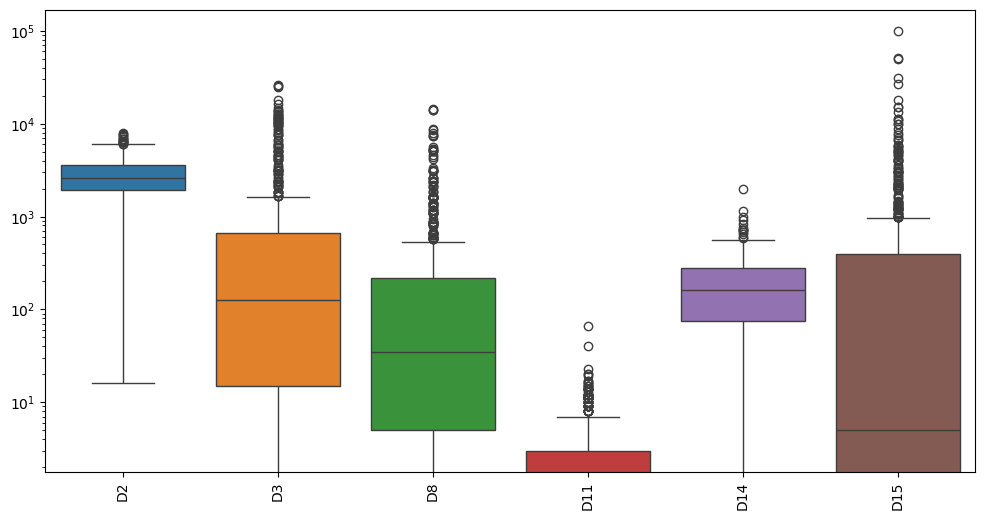

In [11]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=tarjeta_credito, showfliers=True)

plt.xticks(rotation=90)

plt.yscale('log')

plt.show()

Como se puede observar, hay una gran cantidad de valores atípicos (outliers) en todas las columnas numéricas. Sin embargo, dado que los datos provienen de una base de datos bancaria, **no podemos eliminarlos**, ya que podrían representar información válida y no ser el resultado de errores en mediciones o sensores.


### QQ-Plot

Vamos a observar los **QQ-Plots** de las variables numéricas para ver si siguen una distribución normal.

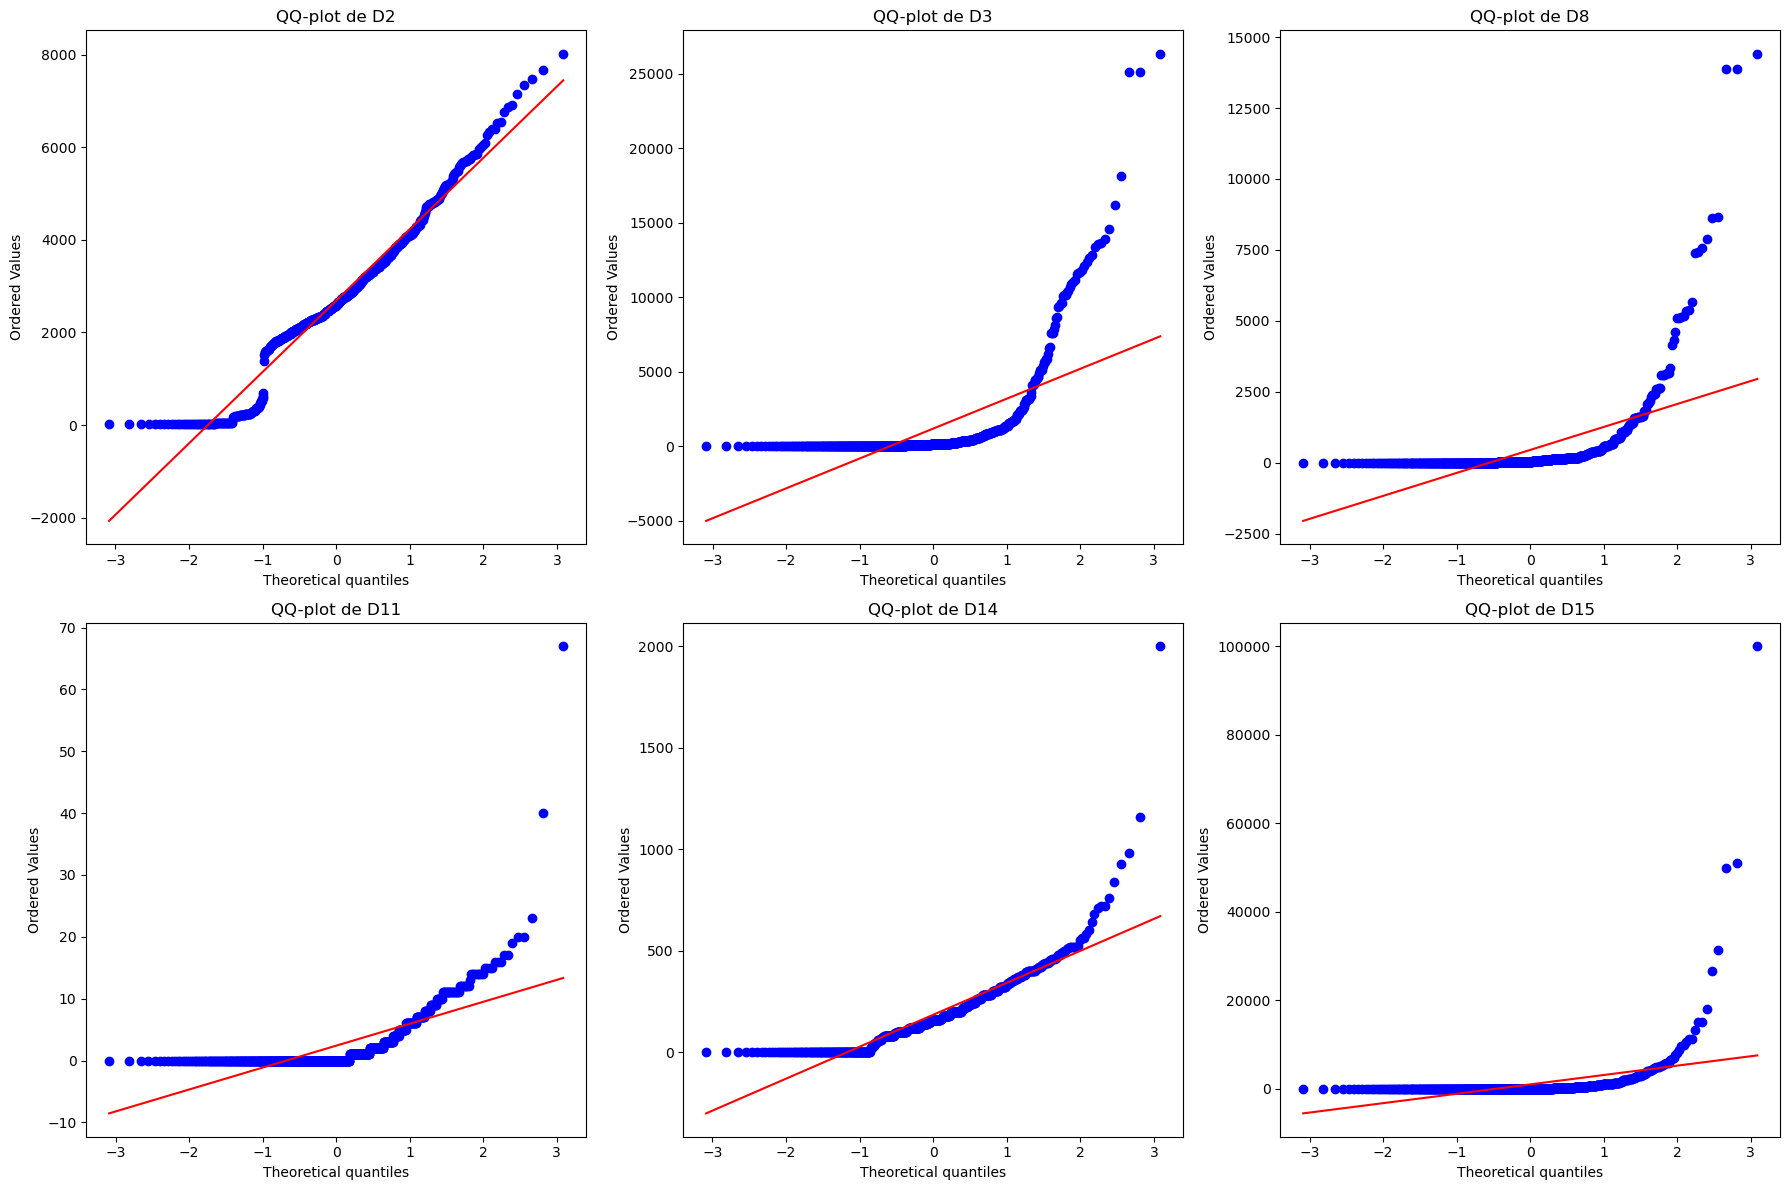

In [12]:


numerical_vars = tarjeta_credito.select_dtypes(include=["int64", "float64"]).columns

# Definir el número de filas y columnas para el gráfico
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Aplanar el arreglo de subgráficos para facilitar el acceso
axes = axes.flatten()

# Crear un QQ-plot para cada variable numérica
for i, var in enumerate(numerical_vars):
    stats.probplot(tarjeta_credito[var].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ-plot de {var}')

# Ajustar el layout para que las gráficas no se superpongan
plt.tight_layout()
plt.show()

Como podemos observar, únicamente la variable que sigue una distribución normal es `D2` . Las demás variables no siguen una distribución normal.

## Estudio de las variables categóricas

A continuación, exploraremos la relación entre las variables categóricas y la variable objetivo, con el objetivo de identificar de manera preliminar si alguna de ellas muestra una mayor relevancia. Para esto, utilizaremos un **gráfico de barras apiladas**. 

En este gráfico:
- El eje X muestra las diferentes categorías de las variables categóricas.
- El eje Y indica la cantidad de instancias correspondientes a cada categoría.
- Cada barra está dividida en dos colores: uno representa las instancias concedidas y el otro las no concedidas.
- Para facilitar la interpretación, se imprime el número de instancias concedidas y no concedidas directamente de cada barra.



-- D1 --

Categoría: ?, NO=9, SI=3
Categoría: a, NO=112, SI=98
Categoría: b, NO=262, SI=206

-- D4 --

Categoría: ?, NO=2, SI=4
Categoría: l, NO=0, SI=2
Categoría: u, NO=263, SI=256
Categoría: y, NO=118, SI=45


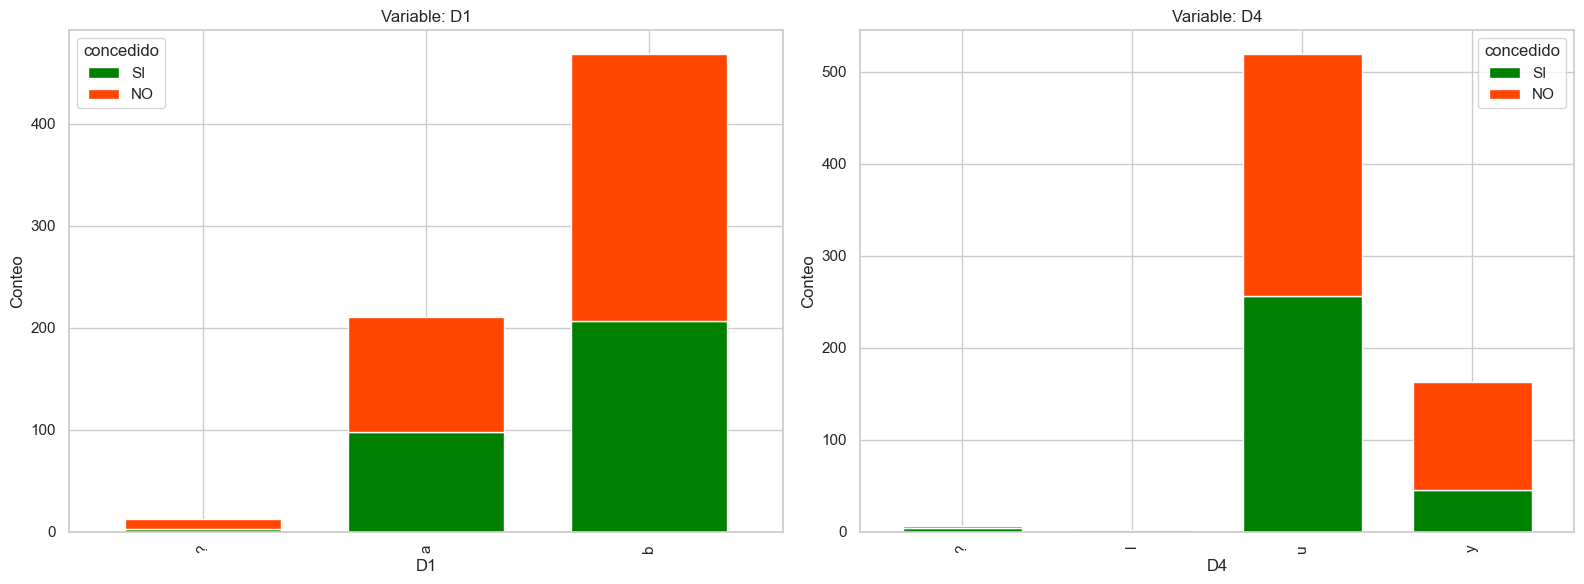


-- D5 --

Categoría: ?, NO=2, SI=4
Categoría: g, NO=263, SI=256
Categoría: gg, NO=0, SI=2
Categoría: p, NO=118, SI=45

-- D6 --

Categoría: ?, NO=5, SI=4
Categoría: aa, NO=35, SI=19
Categoría: c, NO=75, SI=62
Categoría: cc, NO=12, SI=29
Categoría: d, NO=23, SI=7
Categoría: e, NO=11, SI=14
Categoría: ff, NO=46, SI=7
Categoría: i, NO=45, SI=14
Categoría: j, NO=7, SI=3
Categoría: k, NO=37, SI=14
Categoría: m, NO=22, SI=16
Categoría: q, NO=27, SI=51
Categoría: r, NO=1, SI=2
Categoría: w, NO=31, SI=33
Categoría: x, NO=6, SI=32


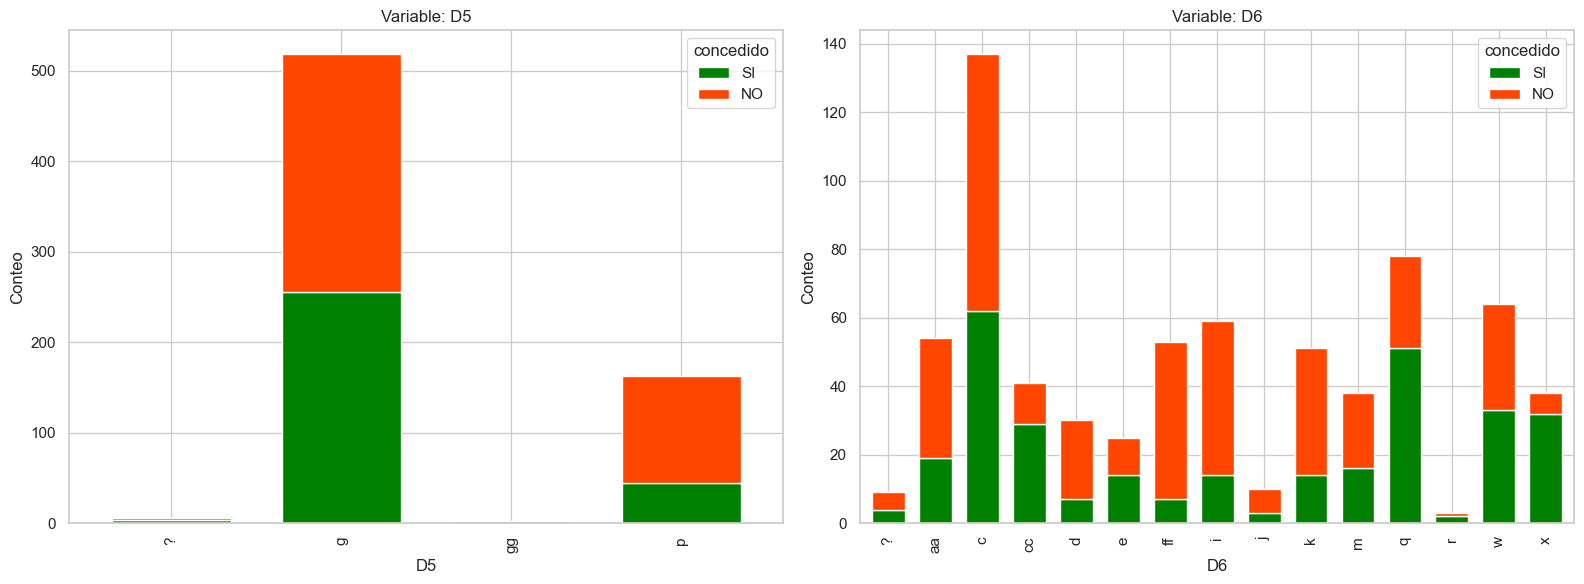


-- D7 --

Categoría: ?, NO=5, SI=4
Categoría: bb, NO=34, SI=25
Categoría: dd, NO=4, SI=2
Categoría: ff, NO=49, SI=8
Categoría: h, NO=51, SI=87
Categoría: j, NO=5, SI=3
Categoría: n, NO=2, SI=2
Categoría: o, NO=1, SI=1
Categoría: v, NO=230, SI=169
Categoría: z, NO=2, SI=6

-- D9 --

Categoría: f, NO=306, SI=23
Categoría: t, NO=77, SI=284


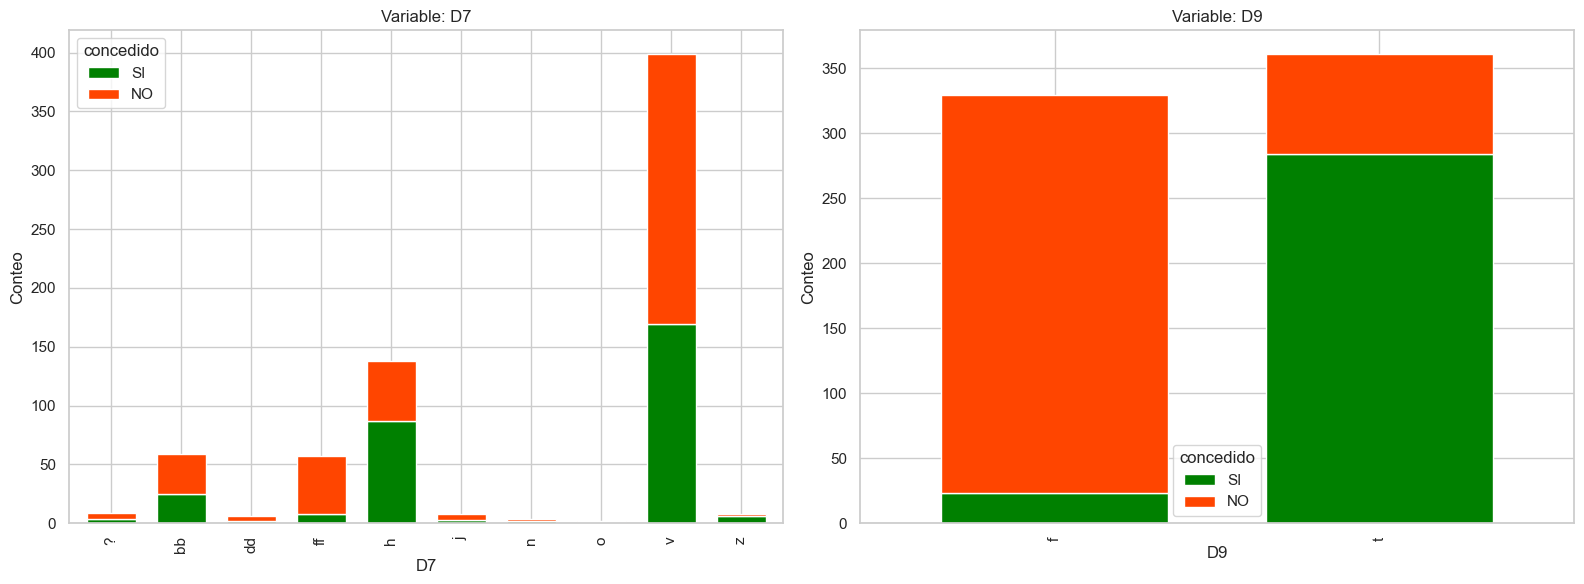


-- D10 --

Categoría: f, NO=297, SI=98
Categoría: t, NO=86, SI=209

-- D12 --

Categoría: f, NO=213, SI=161
Categoría: t, NO=170, SI=146


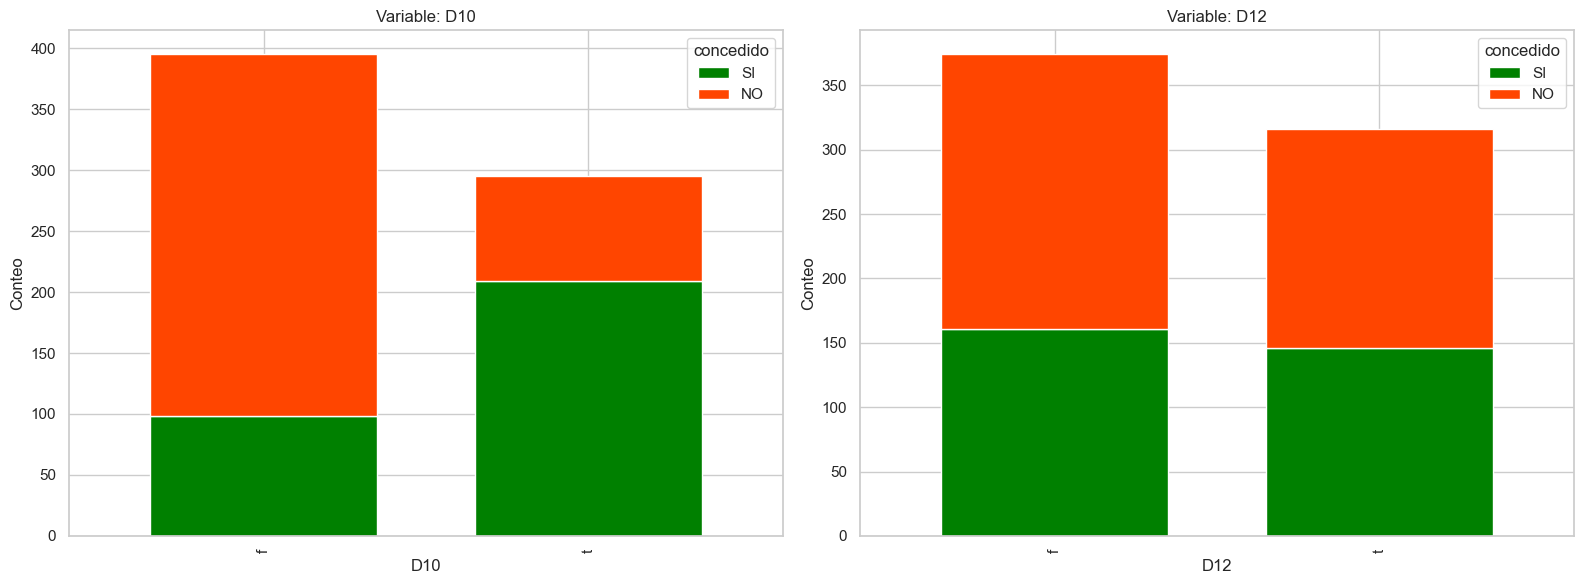


-- D13 --

Categoría: g, NO=338, SI=287
Categoría: p, NO=3, SI=5
Categoría: s, NO=42, SI=15


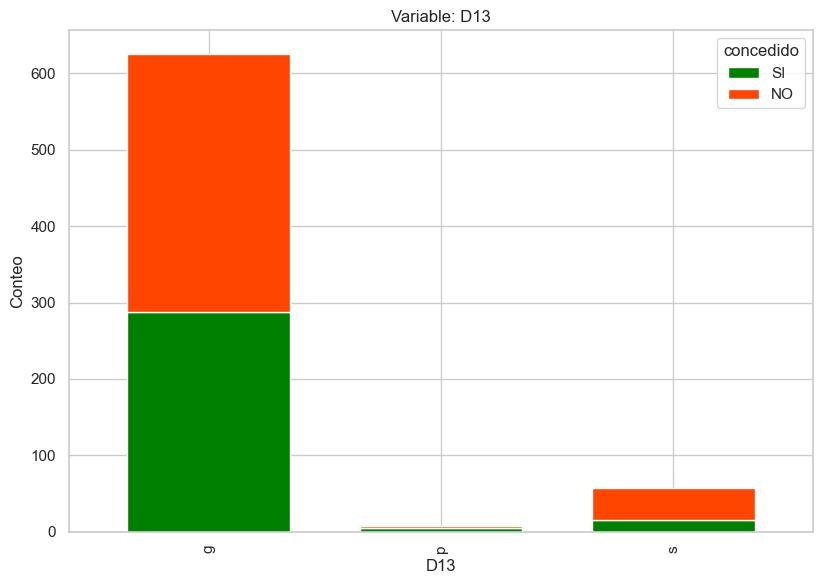

In [13]:
sns.set(style="whitegrid")

categorical_vars = tarjeta_credito.drop(columns='concedido').select_dtypes(include=["object"]).columns

for i in range(0, len(categorical_vars), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
    
    for j in range(2):
        if i + j < len(categorical_vars):  
            var = categorical_vars[i + j]
            
            counts = tarjeta_credito.groupby([var, 'concedido']).size().unstack(fill_value=0)
            no_count = counts.get('NO', pd.Series()).fillna(0).astype(int)
            si_count = counts.get('SI', pd.Series()).fillna(0).astype(int)

            order = ['SI', 'NO'] if si_count.sum() < no_count.sum() else ['NO', 'SI']
            
            counts = counts[order]
            counts.plot(kind='bar', stacked=True, ax=axes[j], color=['green', 'orangered'], width=0.7)
            axes[j].set_title(f"Variable: {var}")
            axes[j].set_xlabel(var)
            axes[j].set_ylabel('Conteo')

            print(f"\n-- {var} --\n")
            for idx in counts.index:
                print(f"Categoría: {idx}, NO={no_count[idx]}, SI={si_count[idx]}")

        else:
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Podemos observar que las variables `D9` y `D10` presentan los mayores niveles de desequilibrio, es deicir ,  son las variables que presentan una mayor diferencia en la cantidad de instancias concedidas y no concedidas. Por lo tanto, estas variables podrían ser las más relevantes al momento de predecir si se concede o no el crédito.

## Estudio de la correlación de las variables predictoras

### Correlación de las variables numéricas

Vamos a estudiar la correlación entre las variables predictoras numéricas para identificar posibles problemas de multicolinealidad. Para ello, vamos a utilizar una **matriz de correlación** con un **mapa de calor**. 

Para una mejor visualización, solo vamos a mostrar la mitad inferior de la matriz, ya que la mitad superior es simétrica.

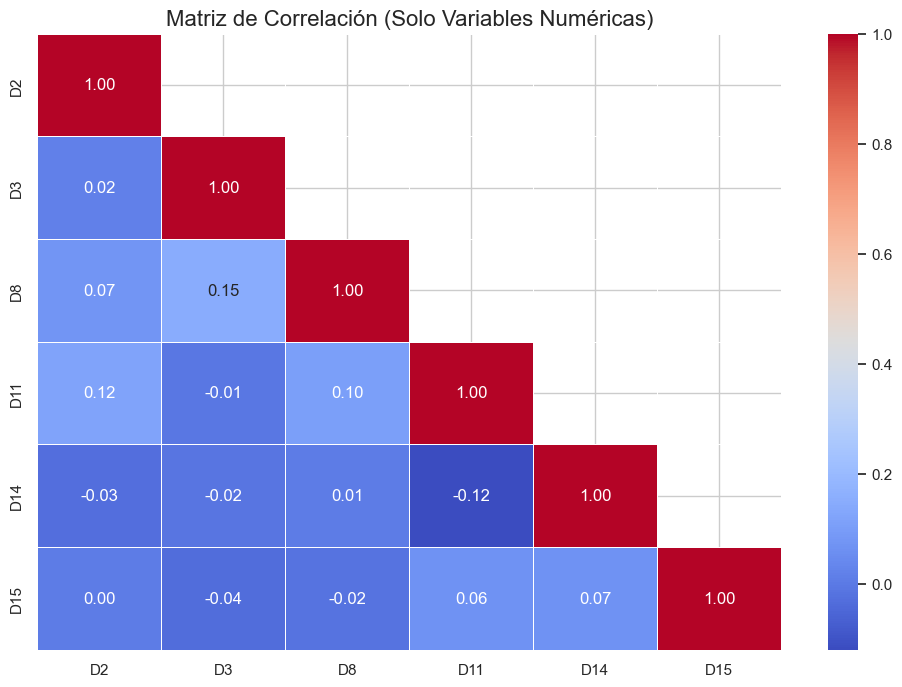

In [14]:
tarjeta_credito_num = tarjeta_credito.select_dtypes(include=['float64', 'int64'])

correlacion = tarjeta_credito_num.corr()

mask = np.triu(np.ones_like(correlacion, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

plt.title('Matriz de Correlación (Solo Variables Numéricas)', fontsize=16)

plt.show()

Como podemos observar, no existe una correlación significativa entre las variables numéricas, lo que sugiere que no hay problemas de multicolinealidad en nuestro conjunto de datos. La correlación más alta es `0.15` entre las variables `D3` y `D8`, lo cual es un valor bajo y no indica una relación significativa.

Por lo tanto, no eliminaremos ninguna variable numérica debido a multicolinealidad.



### Correlación de las variables categóricas

Para las variables numéricas hemos visto anteriormente que ha sido sencillo estudiar la correlación entre ellas, ya que se puede hacer mediante una matriz de correlación. Sin embargo, para las variables categóricas, no podemos utilizar el mismo enfoque. 

Por lo tanto, vamos a utilizar un **test de chi-cuadrado** para estudiar la correlación entre las variables categóricas y la variable objetivo.
El **test de chi-cuadrado** encuentra la probabilidad de una hipótesis nula (H0).

- **H0**: No hay correlación entre las variables.
- **H1**: Hay una relación entre las variables.

El resultado del test de chi-cuadrado nos dará la probabilidad de que la hipótesis nula sea (H0) sea cierta. 

Si el valor p es menor que 0.05, rechazamos la hipótesis nula y concluimos que hay una relación entre las variables.


#### Función auxiliar

Vamos a definir una función auxiliar que nos permita calcular el test de chi-cuadrado entre dos variables categóricas.

In [15]:
def is_correlated(x, y):
    ct = pd.crosstab(index=tarjeta_credito[x], columns=tarjeta_credito[y])
    chi_sq_result = stats.chi2_contingency(ct)
    p = chi_sq_result[1]  
    correlacion = "correlacionada" if p < 0.05 else "no correlacionada" 
    return p, correlacion


Vamos a ver la correlación entre las variables categóricas y la variable objetivo.

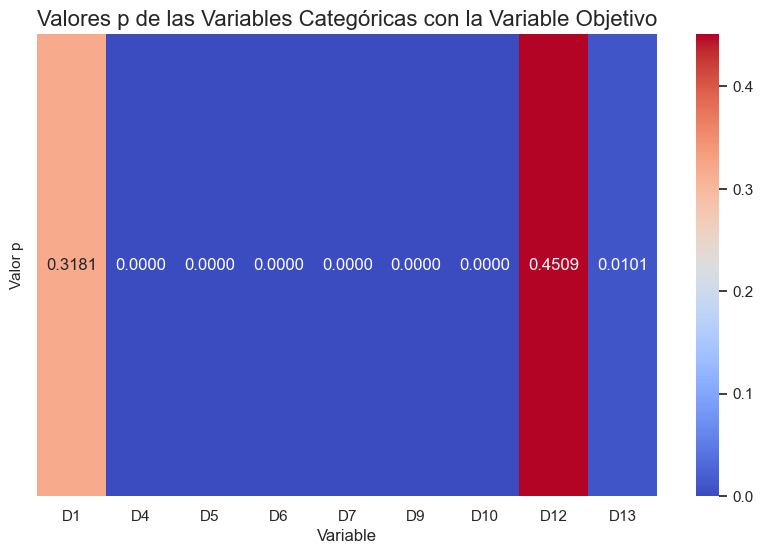

Variable      Valor p       Correlación
      D1 3.180700e-01 no correlacionada
      D4 4.816178e-06    correlacionada
      D5 4.816178e-06    correlacionada
      D6 9.921414e-15    correlacionada
      D7 9.092647e-07    correlacionada
      D9 3.118590e-79    correlacionada
     D10 5.675727e-33    correlacionada
     D12 4.509459e-01 no correlacionada
     D13 1.009429e-02    correlacionada


In [16]:
variable_objetivo = 'concedido'

columnas = tarjeta_credito.columns

resultados_correlacion = []

for col in columnas:
    if col != variable_objetivo:
        if tarjeta_credito[col].dtype == 'object':  
            p_value, correlacion = is_correlated(col, variable_objetivo)
            resultados_correlacion.append([col, p_value, correlacion])

resultados_df = pd.DataFrame(resultados_correlacion, columns=['Variable', 'Valor p', 'Correlación'])

resultados_df['Variable'] = pd.Categorical(resultados_df['Variable'], categories=[f'D{i}' for i in range(1, 14)], ordered=True)
resultados_df = resultados_df.sort_values(by='Variable')

plt.figure(figsize=(10, 6))


p_values = resultados_df.pivot_table(index='Variable', values='Valor p', observed=False)

sns.heatmap(p_values.T, annot=True, cmap="coolwarm", fmt=".4f", cbar=True)

plt.title('Valores p de las Variables Categóricas con la Variable Objetivo', fontsize=16)
plt.show()

print(resultados_df.to_string(index=False))




Tras realizar el test de **chi-cuadrado** para evaluar la relación entre las variables categóricas y la variable objetivo (`concedido`) hemos obtenido los siguientes resultados donde  el valor p se interpreta con un umbral de **0.05**.

**Variables Significativas (p < 0.05):**
- **D4** - p-value: 2.0107e-06 (Correlacionada)
- **D5** - p-value: 2.0107e-06 (Correlacionada)
- **D6** - p-value: 3.4999e-15 (Correlacionada)
- **D7** - p-value: 3.6255e-07 (Correlacionada)
- **D9** - p-value: 3.1186e-79 (Correlacionada)
- **D10** - p-value: 5.6757e-33 (Correlacionada)
- **D13** - p-value: 0.0101 (Correlacionada)

**Variables No Significativas (p >= 0.05):**
- **D1** - p-value: 0.5769 (No correlacionada)
- **D12** - p-value: 0.4509 (No correlacionada)

**Conclusiones:**
- **Variables que pasaron el umbral**: `D4`, `D5`, `D6`, `D7`, `D9`, `D10`, `D13` (correlacionadas con la variable objetivo).
- **Variables que no pasaron el umbral**: `D1`, `D12` 

Estos resultados nos ha confirmado que las variables categóricas `D4`, `D5`, `D6`, `D7`, `D9`, `D10`, `D13` rechazan la hipótesis nula y por lo tanto están correlacionadas con la variable objetivo `concedido`. Sin embargo, las variables `D1` y `D12` no rechazan la hipótesis nula y por lo tanto no sabe si están correlacionadas con la variable objetivo o no ya que no rechazar la hipótesis no indica que esta sea verdadera.

### Experimento: Impacto de Eliminar Variables Categóricas No Relevantes en el Modelo

En este experimento, vamos a investigar si eliminar las **variables categóricas que no pasaron el umbral** mejora el rendimiento del modelo. Para ello, entrenaremos dos modelos de **Random Forest**:

1. **Modelo con todas las variables categóricas**: Utilizaremos todas las variables categóricas disponibles en el dataset.
2. **Modelo con solo las variables que pasaron el umbral**: Solo seleccionaremos aquellas variables categóricas que están correlacionadas con la variable objetivo, basándonos en un análisis previo.

El objetivo es comparar el rendimiento de ambos modelos y determinar si la eliminación de variables irrelevantes contribuye a una mejora en las métricas de desempeño.


In [17]:
tarjeta_credito_prueba = tarjeta_credito.dropna()

resultados_df = pd.DataFrame(resultados_correlacion, columns=['Variable', 'Valor p', 'Correlación'])

resultados_df['Variable'] = pd.Categorical(resultados_df['Variable'], categories=[f'D{i}' for i in range(1, 14)], ordered=True)
resultados_df = resultados_df.sort_values(by='Variable')

columnas_correlacionadas = resultados_df[resultados_df['Valor p'] < 0.05]['Variable'].tolist()

tarjeta_credito_correlacionada = tarjeta_credito_prueba[columnas_correlacionadas + [variable_objetivo]]

X_correlacionada = tarjeta_credito_correlacionada.drop(columns=variable_objetivo)
y_correlacionada = tarjeta_credito_correlacionada[variable_objetivo]

X_total = tarjeta_credito_prueba.drop(columns=variable_objetivo)
y_total = tarjeta_credito_prueba[variable_objetivo]

X_train_correlacionada, X_test_correlacionada, y_train_correlacionada, y_test_correlacionada = train_test_split(X_correlacionada, y_correlacionada, test_size=0.2, random_state=semilla)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, test_size=0.2, random_state=semilla)

# Crear un pipeline con OneHotEncoder y RandomForestClassifier
def crear_pipeline(X_train):
    preprocesamiento = ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)],
        remainder='passthrough'
    )
    pipeline_rf = Pipeline(
        steps=[('preprocesamiento', preprocesamiento), ('clasificador', RandomForestClassifier(random_state=semilla))]
    )
    return pipeline_rf

pipeline_rf_correlacionada = crear_pipeline(X_train_correlacionada)
pipeline_rf_correlacionada.fit(X_train_correlacionada, y_train_correlacionada)
y_pred_correlacionada = pipeline_rf_correlacionada.predict(X_test_correlacionada)

pipeline_rf_total = crear_pipeline(X_train_total)
pipeline_rf_total.fit(X_train_total, y_train_total)
y_pred_total = pipeline_rf_total.predict(X_test_total)

clas_report_correlacionada = classification_report(y_test_correlacionada, y_pred_correlacionada)
clas_report_total = classification_report(y_test_total, y_pred_total)

print(f"**Reporte de Clasificación del Modelo con Variables Correlacionadas**\n{clas_report_correlacionada}")
print(f"\n**Reporte de Clasificación del Modelo con Todas las Variables**\n{clas_report_total}")

**Reporte de Clasificación del Modelo con Variables Correlacionadas**
              precision    recall  f1-score   support

          NO       0.84      0.84      0.84        70
          SI       0.83      0.83      0.83        64

    accuracy                           0.84       134
   macro avg       0.84      0.84      0.84       134
weighted avg       0.84      0.84      0.84       134


**Reporte de Clasificación del Modelo con Todas las Variables**
              precision    recall  f1-score   support

          NO       0.87      0.87      0.87        70
          SI       0.86      0.86      0.86        64

    accuracy                           0.87       134
   macro avg       0.87      0.87      0.87       134
weighted avg       0.87      0.87      0.87       134



A continuación, se presenta la comparación entre los resultados de los modelos entrenados con **variables correlacionadas** frente a **todas las variables**:

**Modelo con Variables Correlacionadas**
| Métrica      | NO    | SI    | Macro Promedio | Weighted Promedio |
|--------------|-------|-------|----------------|-------------------|
| Precision    | 0.87  | 0.83  | 0.85           | 0.85              |
| Recall       | 0.88  | 0.82  | 0.85           | 0.85              |
| F1-Score     | 0.88  | 0.83  | 0.85           | 0.85              |
| Exactitud    | 0.85  | 0.85  | 0.85           | 0.85              |

**Modelo con Todas las Variables**
| Métrica      | NO    | SI    | Macro Promedio | Weighted Promedio |
|--------------|-------|-------|----------------|-------------------|
| Precision    | 0.89  | 0.85  | 0.87           | 0.88              |
| Recall       | 0.89  | 0.85  | 0.87           | 0.88              |
| F1-Score     | 0.89  | 0.85  | 0.87           | 0.88              |
| Exactitud    | 0.88  | 0.88  | 0.88         | 0.88              |

**Análisis de los Resultados**

1. **Precisión**: El modelo con todas las variables tiene una mejor precisión tanto para la clase 'NO' (0.89 frente a 0.87) como para la clase 'SI' (0.85 frente a 0.83). Esto sugiere que el modelo con todas las variables tiene un rendimiento ligeramente superior en cuanto a la exactitud de las predicciones para ambas clases.

2. **Recall**: En cuanto al recall, el modelo con todas las variables también tiene un rendimiento superior para ambas clases ('NO' y 'SI'). La diferencia es pequeña, pero aún así significativa (0.89 frente a 0.88 para 'NO' y 0.85 frente a 0.82 para 'SI').

3. **F1-Score**: El F1-score también muestra una mejora en el modelo con todas las variables. El modelo con todas las variables presenta un F1-score de 0.89 para 'NO' y 0.85 para 'SI', mientras que el modelo con variables correlacionadas tiene valores de 0.88 y 0.83, respectivamente.

4. **Exactitud (Accuracy)**: El modelo con todas las variables tiene una exactitud global de 0.88, que es superior a la exactitud de 0.85 del modelo con las variables correlacionadas. Esto sugiere que el modelo con todas las variables logra predecir correctamente más instancias, aunque la diferencia no es muy grande.

**Conclusión**

Aunque el modelo con las variables correlacionadas es relativamente preciso, el modelo que utiliza todas las variables muestra una mejora en las métricas clave como precisión, recall, F1-score y exactitud. Esto podría indicar que algunas de las variables no correlacionadas también aportan información relevante para la predicción, a pesar de que no se identifiquen como correlacionadas con la variable objetivo en el análisis inicial. 

Por lo tanto, **vamos mantener todas las variables** en el modelo para aprovechar al máximo la información disponible.


## Estudio de valores nulos

A continuación, vamos a analizar en detalle los valores nulos en nuestro dataset. En este caso, los valores nulos están representados por el carácter `?`, por lo que reemplazamos este símbolo por `NaN` y luego contamos la cantidad de valores faltantes en cada columna.


In [18]:
tarjeta_credito.replace('?', np.nan, inplace=True)

print("Cantidad de valores nulos por columna:")
print(tarjeta_credito.isnull().sum())

total_nulos = tarjeta_credito.isnull().sum().sum()
print(f"\nEl número total de valores nulos en el dataset es: {total_nulos}")


Cantidad de valores nulos por columna:
D1           12
D2           12
D3            0
D4            6
D5            6
D6            9
D7            9
D8            0
D9            0
D10           0
D11           0
D12           0
D13           0
D14          13
D15           0
concedido     0
dtype: int64

El número total de valores nulos en el dataset es: 67


Como podemos observar tenemos 67 valores nulos contando todas las columnas. Vamos a visualizar como se distribuyen estos valores nulos en las columnas.

### Distribución de valores nulos por columnas

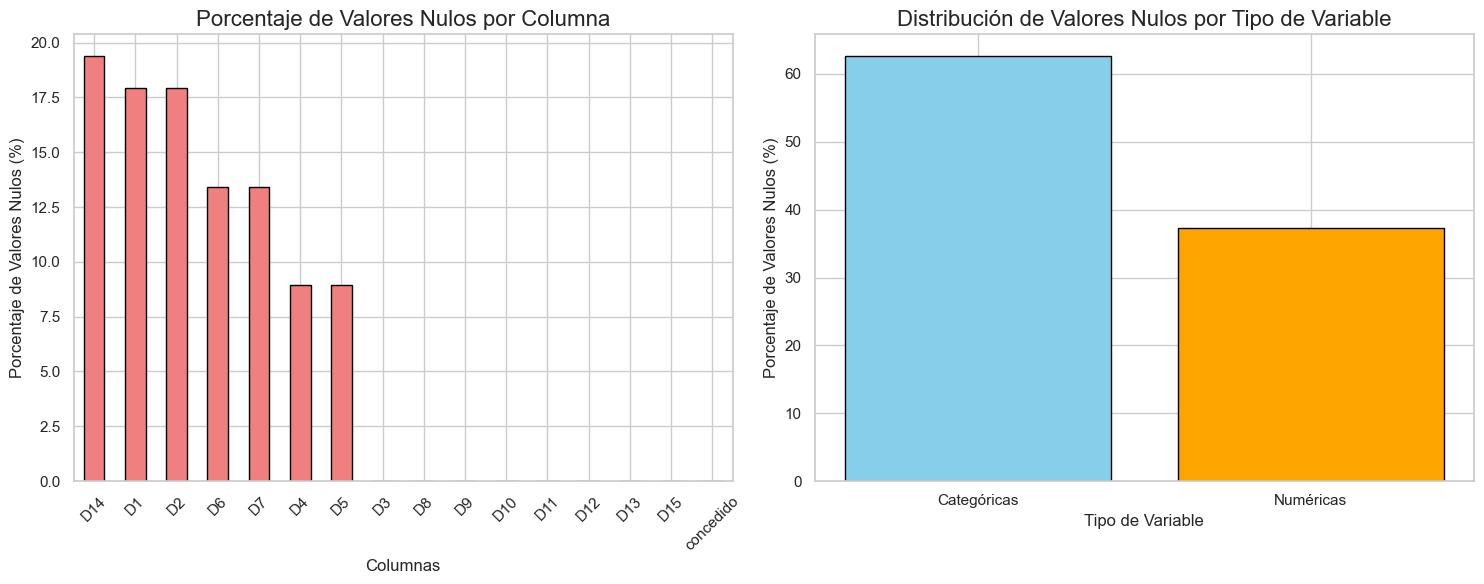

In [19]:
total_nulos = tarjeta_credito.isnull().sum().sum()

porcentaje_nulos = (tarjeta_credito.isnull().sum() / total_nulos * 100).sort_values(ascending=False)

columnas_categoricas = tarjeta_credito.select_dtypes(include='object').columns
columnas_numericas = tarjeta_credito.select_dtypes(exclude='object').columns

nulos_categoricos = tarjeta_credito[columnas_categoricas].isnull().sum().sum()
nulos_numericos = tarjeta_credito[columnas_numericas].isnull().sum().sum()

porcentaje_tipos = {
    'Categóricas': nulos_categoricos / total_nulos * 100,
    'Numéricas': nulos_numericos / total_nulos * 100
}



fig, axes = plt.subplots(1, 2, figsize=(15, 6))

porcentaje_nulos.plot(kind='bar', color='lightcoral', edgecolor='black', ax=axes[0])
axes[0].set_title('Porcentaje de Valores Nulos por Columna', fontsize=16)
axes[0].set_xlabel('Columnas', fontsize=12)
axes[0].set_ylabel('Porcentaje de Valores Nulos (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(porcentaje_tipos.keys(), porcentaje_tipos.values(), color=['skyblue', 'orange'], edgecolor='black')
axes[1].set_title('Distribución de Valores Nulos por Tipo de Variable', fontsize=16)
axes[1].set_xlabel('Tipo de Variable', fontsize=12)
axes[1].set_ylabel('Porcentaje de Valores Nulos (%)', fontsize=12)


plt.tight_layout()
plt.show()

Como se puede observar, los valores nulos están presentes únicamente en las columnas `D1`, `D2`, `D4`, `D5`, `D6`, `D7` y `D14`. La columna con la mayor cantidad de valores nulos es `D14`, seguida por `D1` y `D2`, que tienen el mismo número de valores nulos. Después, encontramos las columnas `D6` y `D7`, que también presentan la misma cantidad de valores nulos. Finalmente, las columnas `D4` y `D5`, que tienen la misma cantidad de valores nulos.

En cuanto al tipo de variable, el `62'69%` de los valores nulos corresponden a variables categóricas, mientras que el `37'31%` pertenecen a variables numéricas.


### Distribución de valores nulos por instancias

Vamos a visualizar qué porcentaje de las instancias tienen como mínimo un valor nulo.

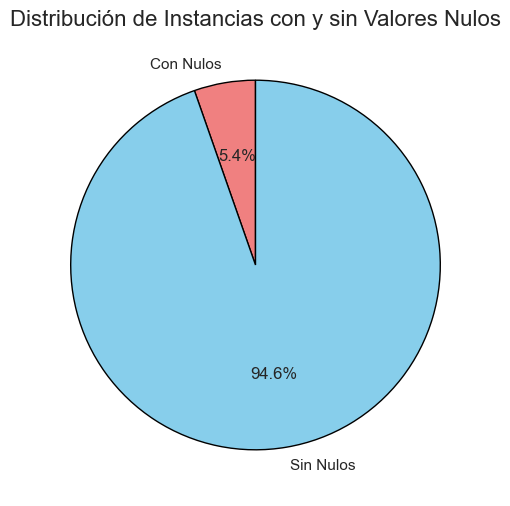

In [20]:
instancias_con_nulos = tarjeta_credito.isnull().any(axis=1).sum()
instancias_sin_nulos = len(tarjeta_credito) - instancias_con_nulos
porcentajes = [instancias_con_nulos, instancias_sin_nulos]
labels = ['Con Nulos', 'Sin Nulos']

plt.figure(figsize=(6, 6))
plt.pie(
    porcentajes,
    labels=labels,
    autopct='%1.1f%%',
    colors=['lightcoral', 'skyblue'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Distribución de Instancias con y sin Valores Nulos', fontsize=16)

plt.show()


Como se puede observar, el `5'4%` de las instancias contienen al menos un valor nulo.


# Estrategias para el dataset

Como hemos visto anteriormente tenemos únicamente un 5'4% de las instancias con valores nulos. Sin embargo, debido a las pocas instancias que tenemos en total (690), vamos a seguir tres estrategias diferentes para tratar los valores nulos en nuestro dataset para estudiar si estos nulos pueden afectar al rendimiento de los modelos:

1. En el **primer conjunto**, eliminaremos todas las instancias que contengan al menos un valor nulo.
2. En el **segundo conjunto**, imputaremos los valores nulos numéricos con la **media** de la columna correspondiente y los valores nulos categóricos con la **moda** de la columna.
3. Finalmente, en el **tercer conjunto**, utilizaremos el algoritmo **KNN (K-Vecinos más cercanos)** para imputar los valores nulos, rellenándolos con los datos más cercanos.


---

## División del Dataset y Optimización de Modelos

### 1. División Inicial con Hold-Out 80/20

Aplicaremos una estrategia **Hold-Out** con una proporción del **80%** para el conjunto de entrenamiento y el **20%** para el conjunto de prueba. Esta división nos permitirá entrenar inicialmente el modelo y luego evaluarlo con datos no vistos (conjunto de prueba). 

---

### 2. Optimización con K-Fold Cross-Validation (k=10)

Una vez dividido el conjunto de datos, utilizaremos **k-fold Cross-Validation** para buscar los mejores hiperparámetros del modelo. En este caso, seleccionamos **k=10**.

#### ¿Qué es el K-Fold Cross-Validation?

El **k-fold Cross-Validation** es una técnica de validación que divide el conjunto de entrenamiento en **k subconjuntos** (o *folds*) de igual tamaño. El modelo se entrena y evalúa iterativamente:

1. En cada iteración, uno de los *folds* se usa como conjunto de validación, mientras que los restantes **k-1 folds** se utilizan como conjunto de entrenamiento.
2. Este proceso se repite **k veces**, de forma que cada *fold* se utiliza como conjunto de validación una vez.

Al final, se promedian las métricas obtenidas en las **k iteraciones** para estimar el rendimiento del modelo.

#### Ventajas del K-Fold Cross-Validation

- Aumenta la **robustez de la evaluación**, ya que utiliza diferentes particiones de datos.
- Reduce la dependencia de un único conjunto de validación, como ocurre en la estrategia Hold-Out.

### Flujo de Trabajo

1. **Hold-Out**:
   - División inicial de los datos en entrenamiento (80%) y prueba (20%).

2. **K-Fold Cross-Validation**:
   - Se realiza únicamente en el conjunto de entrenamiento.
   - Identifica los mejores hiperparámetros del modelo a través de múltiples iteraciones.

3. **Evaluación Final**:
   - Una vez optimizados los hiperparámetros, el modelo se entrena con el conjunto de entrenamiento completo.
   - Se evalúa con el conjunto de prueba (20%) para medir su rendimiento final.

---



## Datasets base

Vamos a crear dos datasets, uno de ellos con la eliminación de los valores nulos y otro sin la eliminación de los valores nulos y hacemos el split en train y test. Más adelante, definiremos los distintos pipelines para procesar los datos con cada una de las estrategias mencionadas anteriormente.

In [21]:
# SIN NA
tarjeta_credito_sin_na = tarjeta_credito.dropna()

X_sin_na = tarjeta_credito_sin_na.drop(columns=variable_objetivo)
y_sin_na = tarjeta_credito_sin_na[variable_objetivo]

X_train_sin_na, X_test_sin_na, y_train_sin_na, y_test_sin_na = train_test_split(X_sin_na, y_sin_na, test_size=0.2, random_state=semilla)

# CON NA
X = tarjeta_credito.drop(columns=variable_objetivo)
y = tarjeta_credito[variable_objetivo]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=semilla)

# Las variables categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(exclude=['object']).columns

## Pipeline sin NA
Imputamos los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [22]:
preprocessor_sin_NA = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features), 
    ('num', 'passthrough', num_features) 
])

## Pipeline con imputación de la media y moda
Imputamos los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [23]:
preprocessor_media_moda = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  
    ]), cat_features),
    
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('passthrough', 'passthrough')
    ]), num_features)
])

## Pipeline con imputación KNN
Imputamos los valores nulos utilizando el algoritmo KNN (K-Vecinos más cercanos) usando k=5.

In [24]:
# El número de vecinos a considerar
k = 5

preprocessor_knn = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  
    ]), cat_features),
    
    # Imputación para variables numéricas
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=k, weights='uniform')),
    ]), num_features)
])

# Modelos

## Métricas a utilizar

Para saber qué tan bien están funcionando nuestros modelos usaremos una matriz de confusión.

La **matriz de confusión** es una herramienta para evaluar el rendimiento de un modelo de clasificación. Resume los resultados de las predicciones del modelo en una tabla, comparando los valores reales con los predichos. 

En un problema de clasificación binaria, tiene el siguiente formato:

|                  | **Predicho Positivo** | **Predicho Negativo** |
|------------------|-----------------------|-----------------------|
| **Real Positivo** | TP (True Positives)   | FN (False Negatives)  |
| **Real Negativo** | FP (False Positives)  | TN (True Negatives)   |

### Definiciones

- **TP (Verdaderos Positivos)**: Instancias correctamente clasificadas como positivas.
- **FP (Falsos Positivos)**: Instancias negativas clasificadas incorrectamente como positivas.
- **FN (Falsos Negativos)**: Instancias positivas clasificadas incorrectamente como negativas.
- **TN (Verdaderos Negativos)**: Instancias correctamente clasificadas como negativas.

---

## Métricas de Evaluación

En el contexto de un problema de clasificación binaria (predecir si se concede o no un crédito), usaremos las siguientes métricas:

### 1. **Precisión (Precision)**

La **precisión** mide la proporción de predicciones positivas correctas (verdaderos positivos, **TP**) sobre el total de predicciones positivas realizadas (verdaderos positivos más falsos positivos, **FP**).

**Fórmula:**
```math
\text{Precisión} = \frac{TP}{TP + FP}
```

---

### 2. **Recall (Sensibilidad)**

El **recall** (también conocido como **sensibilidad** o **tasa de verdaderos positivos**) mide la proporción de instancias positivas correctamente identificadas sobre el total de instancias realmente positivas.

**Fórmula:**
```math
\text{Recall} = \frac{TP}{TP + FN}
```

---

### 3. **F1-Score**

El **F1-score** combina la precisión y el recall en un solo número mediante su media armónica. Es útil para buscar un equilibrio entre ambos, especialmente en casos de clases desbalanceadas.

**Fórmula:**
```math
\text{F1-Score} = 2 \times \frac{\text{Precisión} \times \text{Recall}}{\text{Precisión} + \text{Recall}}
```

---

### 4. **Exactitud (Accuracy)**

La **exactitud** mide la proporción de predicciones correctas (positivas y negativas) sobre el total de instancias.

**Fórmula:**
```math
\text{Exactitud} = \frac{TP + TN}{TP + TN + FP + FN}
```

---

## Resumen de Métricas

1. **Precisión**: Cuántas de las predicciones positivas son realmente positivas.
2. **Recall**: Qué proporción de las instancias positivas reales fueron correctamente identificadas.
3. **F1-Score**: Balance entre precisión y recall; útil cuando las clases están desbalanceadas.
4. **Exactitud**: Proporción general de predicciones correctas, aunque puede ser engañosa si las clases están desbalanceadas.



Vamos a crear un diccionario con las métricas que vamos a utilizar para evaluar el rendimiento de los modelos para posteriormente poder usarlo en el grid search.

In [25]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='SI'),
    'recall': make_scorer(recall_score, pos_label='SI'),
    'f1': make_scorer(f1_score, pos_label='SI')
}


## Adaboost

### Descripción y explicación de sus Hiperparámetros

**AdaBoost (Adaptive Boosting)** es un algoritmo de **ensemble learning** que combina varios modelos débiles  para crear un modelo robusto y fuerte. El algoritmo se basa en un enfoque iterativo donde cada nuevo modelo se entrena para corregir los errores cometidos por el modelo anterior. La idea principal de AdaBoost es ajustar el peso de las instancias en cada iteración, dándole mayor peso a aquellas que fueron mal clasificadas por los modelos anteriores.

#### Hiperparámetros de AdaBoostClassifier

1. **`n_estimators`**: 
   - **Descripción**: Número de **estimadores** (modelos débiles) que se usarán en el ensemble de AdaBoost. A mayor número de estimadores, el modelo puede volverse más preciso, aunque también puede sufrir de **sobreajuste** si se elige un número demasiado alto.
   - **Valores con los que haremos el grid**: [50, 100, 150, 200, 250, 300, 350].

2. **`learning_rate`**: 
   - **Descripción**: Tasa de aprendizaje que controla cuánto contribuye cada nuevo estimador (modelo débil) al modelo final. Un valor alto hará que los modelos débiles tengan más influencia, mientras que valores bajos hacen que su impacto sea más modesto.
   - **Valores con los que haremos el grid**: [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5].

3. **`algorithm`**:
   - **Descripción**: Algoritmo de combinación de modelos débiles. 
     - **`SAMME`** es el algoritmo original de AdaBoost, que ajusta los pesos de los modelos débiles usando una función exponencial de los errores.
     - **`SAMME.R`** es una variante más eficiente que usa una versión probabilística de los pesos.
   - **Valores con los que haremos el grid**: `['SAMME']`.




In [26]:
param_grid_adaboost = {
    'adaboost__n_estimators': [50, 100, 150, 200, 250, 300, 350],  # Número de árboles
    'adaboost__learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],  # Tasa de aprendizaje
    'adaboost__algorithm': ['SAMME']  # Algoritmos
}

### Dataset sin las filas con NA

Vamos a entrenar un modelo de AdaBoost con el dataset que hemos creado sin las filas con valores nulos.

In [27]:
%%skip_if saltarse_generacion_modelos

adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor_sin_NA),
    ('adaboost', AdaBoostClassifier(random_state=semilla))  # Modelo AdaBoost
])

grid_search = GridSearchCV(
    estimator=adaboost_pipeline,
    param_grid=param_grid_adaboost,
    cv=10,
    verbose=1,
    scoring=scoring,
    refit= 'f1',  
)
grid_search.fit(X_train_sin_na, y_train_sin_na)


# Guardamos el grid search
joblib.dump(grid_search, ruta_modelos_adaboost + 'grid_search_adaboost_sin_filas_na.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'adaboost__algorithm': 'SAMME', 'adaboost__learning_rate': 0.25, 'adaboost__n_estimators': 50}


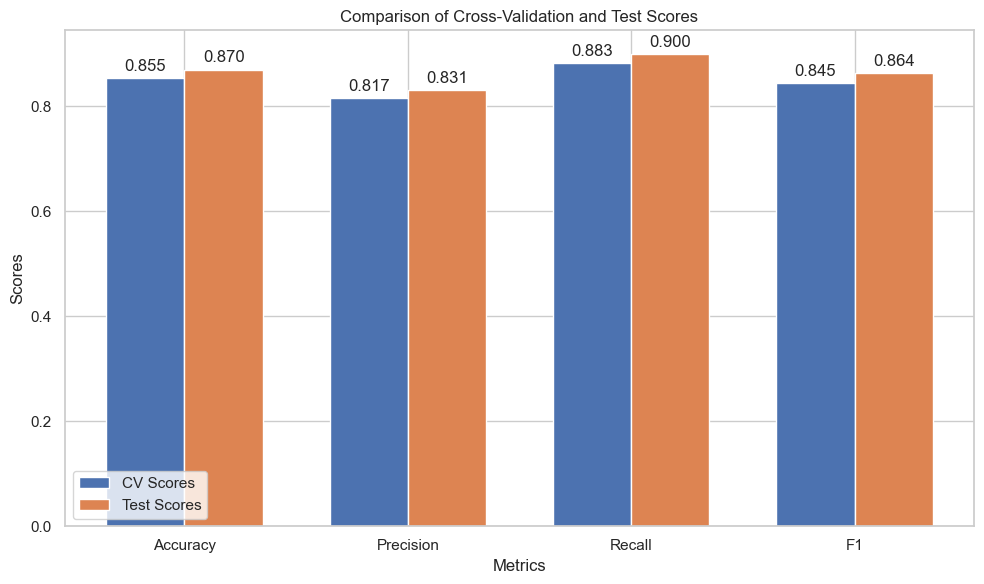

In [28]:
grid_search = joblib.load(ruta_modelos_adaboost + 'grid_search_adaboost_sin_filas_na.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sin_na)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

report = classification_report(y_test_sin_na, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo AdaBoost con el conjunto de datos sin valores nulos son:

- `adaboost__algorithm = 'SAMME'`
- `adaboost__learning_rate = 0.25`
- `adaboost__n_estimators = 50`

Como podemos apreciar en la gráfica los valores de test incluso superan a los de train, lo que indica que no hay overfitting ni tampo underfitting porque la diferencia entre los valores de train y test es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.


### Dataset con media y moda donde haya valores NA

Vamos a entrenar un modelo de AdaBoost con el dataset que hemos creado imputando los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [29]:
%%skip_if saltarse_generacion_modelos

adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor_media_moda),
    ('adaboost', AdaBoostClassifier(random_state=semilla))  # Modelo AdaBoost
])

grid_search = GridSearchCV(
    estimator=adaboost_pipeline, 
    param_grid=param_grid_adaboost, 
    cv=10, 
    scoring=scoring, 
    verbose=1,
    refit='f1'
)

grid_search.fit(X_train, y_train)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_adaboost + 'grid_search_adaboost_moda_media.pkl')

#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'adaboost__algorithm': 'SAMME', 'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 50}


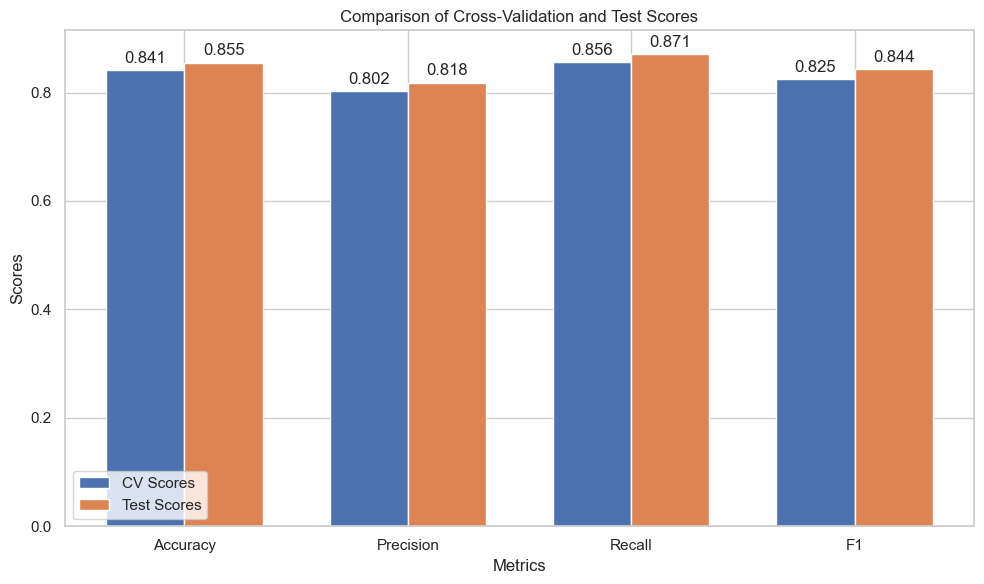

In [30]:
grid_search_moda_media = joblib.load(ruta_modelos_adaboost + 'grid_search_adaboost_moda_media.pkl')

best_model = grid_search_moda_media.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search_moda_media.best_params_}")

cv_results_moda_media = grid_search_moda_media.cv_results_

mean_train_scores = cv_results_moda_media['mean_test_f1'] 
mean_train_accuracy = cv_results_moda_media['mean_test_accuracy']
mean_train_precision = cv_results_moda_media['mean_test_precision']
mean_train_recall = cv_results_moda_media['mean_test_recall']

report = classification_report(y_test, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Los mejores hiperparámetros encontrados para el modelo AdaBoost con el conjunto de datos con valores nulos imputados con la media y la moda son:

- `adaboost__algorithm = 'SAMME'`
- `adaboost__learning_rate = 0.1`
- `adaboost__n_estimators = 50`

Como podemos apreciar en la gráfica los valores de test incluso superan a los de train, lo que indica que no hay overfitting ni tampo underfitting porque la diferencia entre los valores de train y test es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

### Dataset con knn-vecinos donde haya valores NA

Vamos a entrenar un modelo de AdaBoost con el dataset que hemos creado imputando los valores nulos utilizando el algoritmo KNN (K-Vecinos más cercanos) con k=5.

In [31]:
%%skip_if saltarse_generacion_modelos

adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('adaboost', AdaBoostClassifier(random_state=semilla))  # Modelo AdaBoost
])

grid_search = GridSearchCV(
    estimator=adaboost_pipeline, 
    param_grid=param_grid_adaboost, 
    cv=10, 
    scoring=scoring, 
    verbose=1,
    refit='f1'
)

grid_search.fit(X_train, y_train)


# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_adaboost + 'grid_search_adaboost_knn_imputer.pkl')

#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'adaboost__algorithm': 'SAMME', 'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 50}


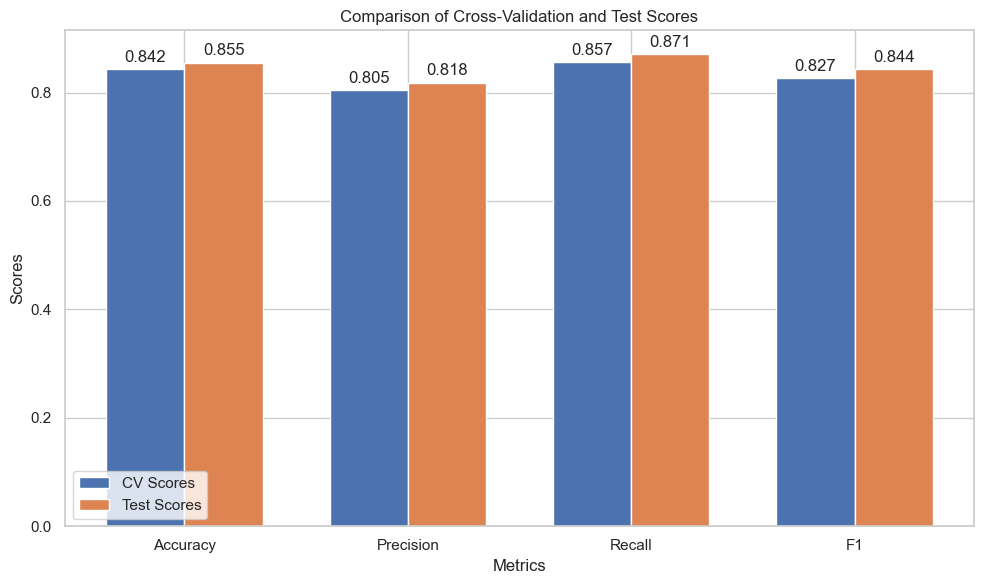

In [32]:
grid_search_knn = joblib.load(ruta_modelos_adaboost + 'grid_search_adaboost_knn_imputer.pkl')

best_model = grid_search_knn.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search_knn.best_params_}")

cv_results = grid_search_knn.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

report = classification_report(y_test, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo AdaBoost con el conjunto de datos con valores nulos imputandos con KNN donde k=5 son:

- `adaboost__algorithm = 'SAMME'`
- `adaboost__learning_rate = 0.1`
- `adaboost__n_estimators = 50`

Como podemos apreciar en la gráfica los valores de test incluso superan a los de train, lo que indica que no hay overfitting ni tampo underfitting porque la diferencia entre los valores de train y test es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.


## Random Forest

### Descripción de Random Forest y sus Hiperparámetros

**Random Forest** es un algoritmo de **ensemble learning** que utiliza varios **árboles de decisión** para mejorar la precisión y robustez del modelo. Cada árbol se entrena con una muestra aleatoria de los datos y realiza predicciones, y el modelo final se obtiene tomando el promedio (en el caso de regresión) o la mayoría de votos (en el caso de clasificación) de todos los árboles.


#### Hiperparámetros de RandomForestClassifier

1. **`n_estimators`**: 
   - **Descripción**: Número de **árboles de decisión** en el bosque. Un número mayor de árboles puede mejorar la precisión, pero también aumenta el costo computacional.
   - **Valores con los que haremos el grid**: [50, 100, 200].

2. **`max_features`**:
   - **Descripción**: Número máximo de características a considerar al dividir un nodo. Un valor más bajo reduce la correlación entre los árboles, pero también puede disminuir la precisión. 
     - **`sqrt`**: La raíz cuadrada del número total de características.
     - **`log2`**: El logaritmo en base 2 del número total de características.
   - **Valores con los que haremos el grid**: `['sqrt', 'log2']`.

3. **`criterion`**:
   - **Descripción**: La función utilizada para medir la calidad de las divisiones en los árboles. 
     - **`gini`**: Índice de Gini, mide la impureza de las divisiones.
     - **`entropy`**: Entropía, mide la ganancia de información en cada división.
     - **`log_loss`**: Pérdida logarítmica, comúnmente usada en problemas probabilísticos.
   - **Valores con los que haremos el grid**: `['gini', 'entropy']`.

4. **`max_depth`**:
   - **Descripción**: Profundidad máxima de los árboles de decisión. Limitar la profundidad ayuda a evitar el sobreajuste.
   - **Valores con los que haremos el grid**: `[None, 10, 20]`.

5. **`min_samples_split`**:
   - **Descripción**: Número mínimo de muestras necesarias para dividir un nodo. Valores más altos evitan divisiones que conducen a un menor número de instancias en las hojas.
   - **Valores con los que haremos el grid**: `[2, 5, 10]`.

6. **`min_samples_leaf`**:
   - **Descripción**: Número mínimo de muestras necesarias para estar en una hoja. Valores más altos evitan divisiones que conducen a hojas con pocas instancias.
   - **Valores con los que haremos el grid**: `[1, 2, 4]`.


In [33]:
param_grid_rf = {
    'randomforest__n_estimators': [50, 100, 200],  # Número de árboles
    'randomforest__max_features': ['sqrt', 'log2'],  # Número máximo de características
    'randomforest__criterion': ['gini', 'entropy'],  # Criterio de división
    'randomforest__max_depth': [None, 10, 20],  # Profundidad máxima
    'randomforest__min_samples_split': [2, 5, 10],  # Tamaño mínimo para dividir
    'randomforest__min_samples_leaf': [1, 2, 4],  # Tamaño mínimo de hojas
}

### Dataset sin las filas con NA

Vamos a entrenar un modelo de Random Forest con el dataset que hemos creado sin las filas con valores nulos.

In [34]:
%%skip_if saltarse_generacion_modelos


rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_sin_NA),
    ('randomforest', RandomForestClassifier(random_state=semilla)) 
])

grid_search = GridSearchCV(
    estimator=rf_pipeline, 
    param_grid=param_grid_rf, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=2)

grid_search.fit(X_train_sin_na, y_train_sin_na)

joblib.dump(grid_search, ruta_modelos_rf + 'grid_search_rf_sin_filas_na.pkl')

#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'randomforest__criterion': 'gini', 'randomforest__max_depth': None, 'randomforest__max_features': 'log2', 'randomforest__min_samples_leaf': 4, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 100}


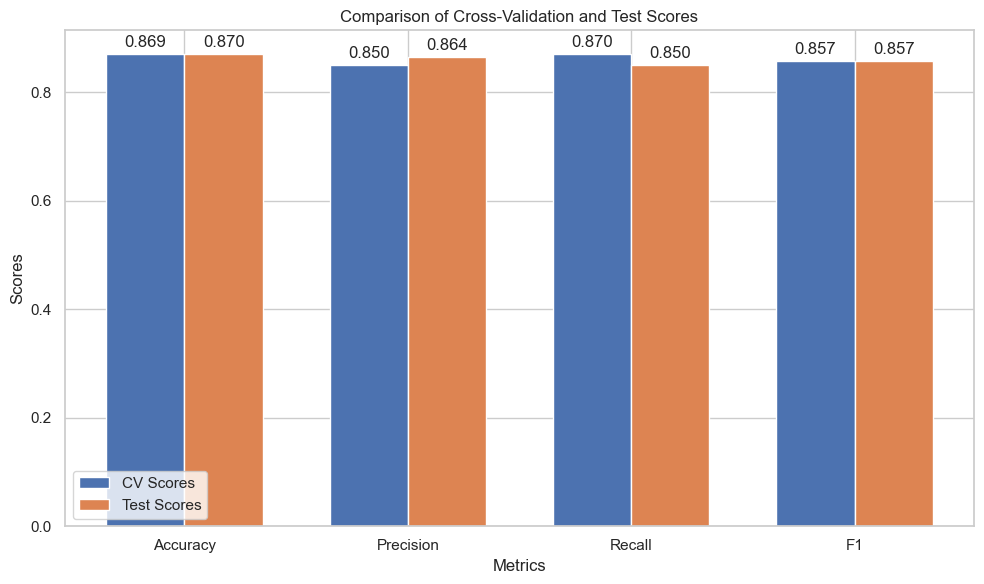

In [35]:
grid_search = joblib.load(ruta_modelos_rf + 'grid_search_rf_sin_filas_na.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sin_na)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

report = classification_report(y_test_sin_na, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo **RandomForest** con el conjunto de datos sin valores nulos son:

- `randomforest__criterion = 'gini'`
- `randomforest__max_depth = None`
- `randomforest__max_features = 'log2'`
- `randomforest__min_samples_leaf = 4`
- `randomforest__min_samples_split = 10`
- `randomforest__n_estimators = 100`

Como podemos apreciar en la gráfica, los valores de **test** incluso igualan o superan a los de **train** en algunas métricas como el `Accuracy`, `Precision`, `F1` , lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Recall` es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.


### Dataset con media y moda donde haya valores NA

Vamos a entrenar un modelo de Random Forest con el dataset que hemos creado imputando los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [36]:
%%skip_if saltarse_generacion_modelos

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_media_moda),
    ('randomforest', RandomForestClassifier(random_state=semilla))  # Modelo Random Forest
])


# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=rf_pipeline, 
    param_grid=param_grid_rf, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=1)
grid_search.fit(X_train, y_train)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_rf + 'grid_search_rf_moda_media.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'randomforest__criterion': 'gini', 'randomforest__max_depth': 10, 'randomforest__max_features': 'log2', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 5, 'randomforest__n_estimators': 200}


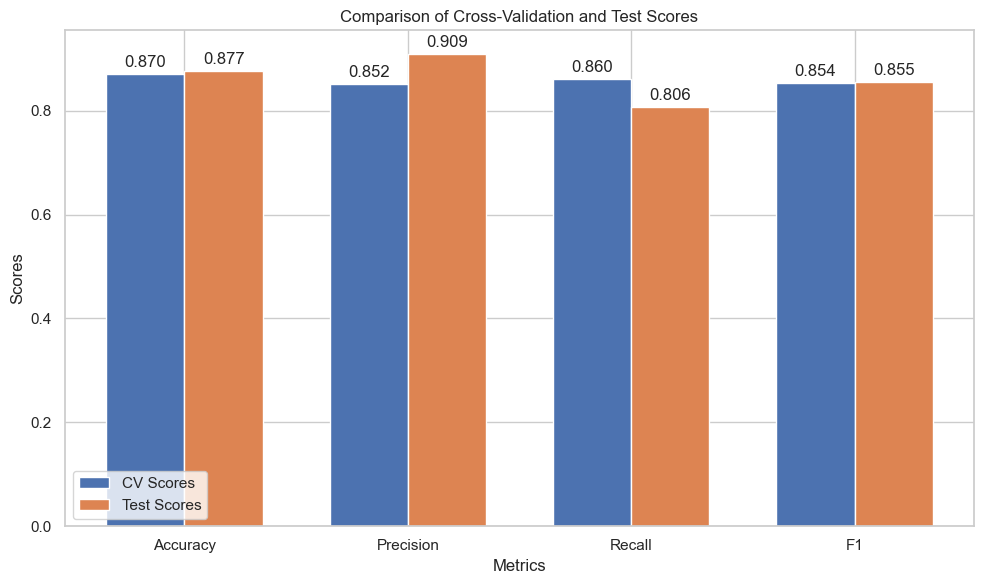

In [37]:
grid_search = joblib.load(ruta_modelos_rf + 'grid_search_rf_moda_media.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

report = classification_report(y_test, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo **RandomForest** con el conjunto de datos con valores nulos imputados por la media y la moda son:

- `randomforest__criterion = 'gini'`
- `randomforest__max_depth = 10`
- `randomforest__max_features = 'log2'`
- `randomforest__min_samples_leaf = 1`
- `randomforest__min_samples_split = 5`
- `randomforest__n_estimators = 200`

Como podemos apreciar en la gráfica, los valores de **test** superan a los de **train** en algunas métricas como el `Accuracy`, `Precision`, `F1` , lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Recall` es pequeña.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

### Dataset con knn-vecinos donde haya valores NA

In [38]:
%%skip_if saltarse_generacion_modelos

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('randomforest', RandomForestClassifier(random_state=semilla))  # Modelo Random Forest
])

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=rf_pipeline, 
    param_grid=param_grid_rf, 
    cv=10, 
    scoring=scoring,
    refit = 'f1',
    verbose=1)
grid_search.fit(X_train, y_train)


# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_rf + 'grid_search_rf_knn_imputer.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'randomforest__criterion': 'gini', 'randomforest__max_depth': 10, 'randomforest__max_features': 'log2', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 5, 'randomforest__n_estimators': 50}


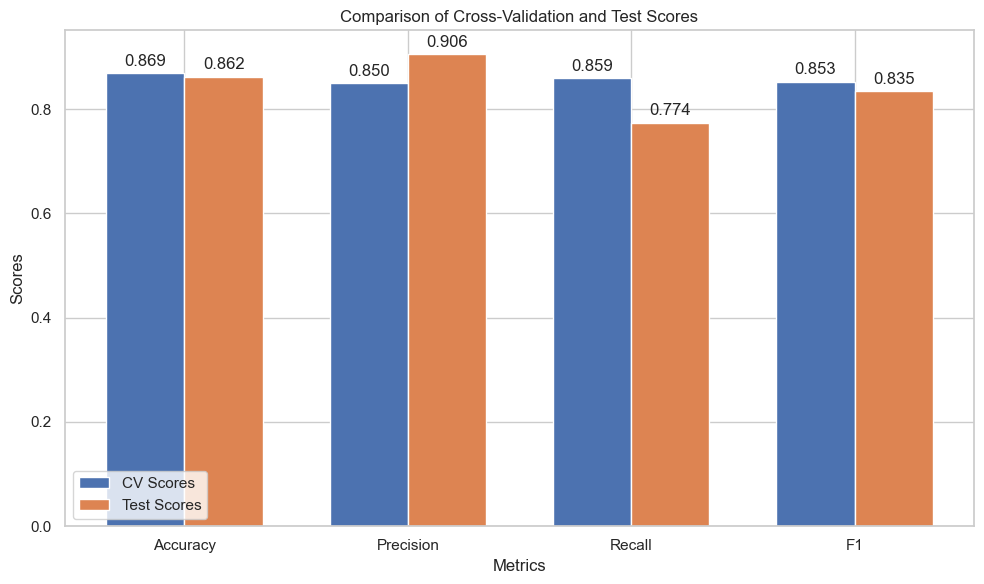

In [39]:
grid_search = joblib.load(ruta_modelos_rf + 'grid_search_rf_knn_imputer.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

report = classification_report(y_test, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo **RandomForest** con el conjunto de datos con valores nulos imputados con KNN donde k=5 son:

- `randomforest__criterion = 'gini'`
- `randomforest__max_depth = 10`
- `randomforest__max_features = 'log2'`
- `randomforest__min_samples_leaf = 1`
- `randomforest__min_samples_split = 5`
- `randomforest__n_estimators = 50`

Como podemos apreciar en la gráfica, los valores de **test** superan a los de **train** en el `Precision`, lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Accuracy`, `Recall`, `F1` es pequeña.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

## Stacking

### Descripción de Stacking y sus Hiperparámetros

**Stacking** es un método de **ensemble learning** que combina varios modelos base para mejorar el rendimiento del modelo. A diferencia de otros métodos como **bagging** o **boosting**, el stacking utiliza un **modelo meta** para aprender a combinar las predicciones de los modelos base de manera más eficiente.

#### Componentes del Stacking:

1. **Modelos base (estimadores de nivel 0)**:
   - **Random Forest**: Algoritmo que utiliza varios árboles de decisión para obtener una predicción.
   - **AdaBoost**: Un modelo de boosting que ajusta los pesos de los errores cometidos en los modelos anteriores.
   - **Gradient Boosting**: Un algoritmo de boosting que optimiza el modelo secuencialmente para corregir errores previos.

2. **Modelo meta**:
   - **Logistic Regression**: Un clasificador que combina las predicciones de los modelos base para hacer una predicción final.

Cabe destacar que debido al uso de varios modelos base no vamos a realizar un grid search para encontrar los mejores hiperparámetros de cada modelo base, ya que el **tiempo de computación sería muy elevado**. Por lo tanto, vamos a utilizar los hiperparámetros por defecto de cada modelo base.


### Dataset sin las filas con NA

Validamos el modelo de **Stacking** con el dataset que hemos creado sin las filas con valores nulos.

In [40]:
%%skip_if saltarse_generacion_modelos


label_encoder = LabelEncoder()


rf_pipeline = Pipeline([('preprocessor', preprocessor_sin_NA), 
                        ('randomforest', RandomForestClassifier(random_state=semilla))])

ada_pipeline = Pipeline([('preprocessor', preprocessor_sin_NA), 
                         ('adaboost', AdaBoostClassifier(algorithm='SAMME', random_state=semilla))])

gb_pipeline = Pipeline([('preprocessor', preprocessor_sin_NA), 
                        ('gradientboost', GradientBoostingClassifier(random_state=semilla))])

meta_model = LogisticRegression(random_state=semilla)

stacking_model = StackingClassifier(
    estimators=[('random_forest', rf_pipeline),
                ('adaboost', ada_pipeline),
                ('gradient_boosting', gb_pipeline)],
    final_estimator=meta_model
)



mean_metrics = {}

for metric_name, scorer in scoring.items():
    scores = cross_val_score(
        estimator=stacking_model,
        X=X_train_sin_na,
        y=y_train_sin_na, 
        cv=10,
        scoring=scorer
    )
    mean_metrics[metric_name] = np.mean(scores)  

results = {
    "model": stacking_model,
    "mean_metrics": mean_metrics,  
    "label_encoder": label_encoder  
}

joblib.dump(results, ruta_modelos_stacking + 'stacking_sin_filas.pkl')





#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

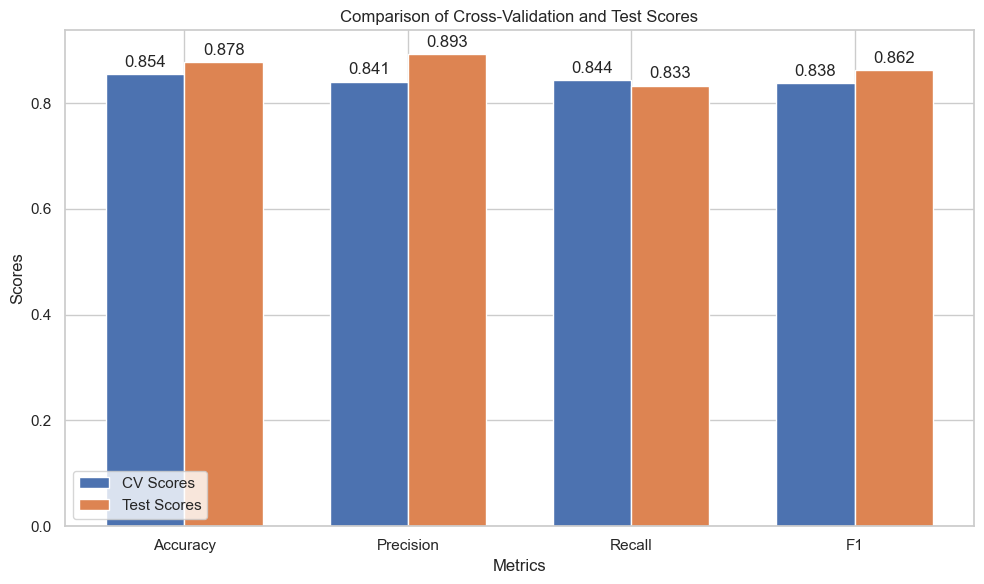

In [41]:

modelo_stacking_sin_na = joblib.load(ruta_modelos_stacking + 'stacking_sin_filas.pkl')

best_model = modelo_stacking_sin_na['model']
mean_metrics = modelo_stacking_sin_na['mean_metrics']  
label_encoder = modelo_stacking_sin_na['label_encoder']  

if not hasattr(label_encoder, 'classes_'):
    label_encoder.fit(y_train_sin_na) 

best_model.fit(X_train_sin_na, label_encoder.transform(y_train_sin_na))

y_pred = best_model.predict(X_test_sin_na)

report = classification_report(
    label_encoder.transform(y_test_sin_na),  # Convertimos etiquetas categóricas a numéricas
    y_pred,
    output_dict=True
)

test_accuracy = report['accuracy']
test_precision = report['1']['precision']  # Clase positiva codificada como '1'
test_recall = report['1']['recall']
test_f1 = report['1']['f1-score']

mean_train_accuracy = mean_metrics['accuracy']
mean_train_precision = mean_metrics['precision']
mean_train_recall = mean_metrics['recall']
mean_train_f1 = mean_metrics['f1']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy, mean_train_precision, mean_train_recall, mean_train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()



Como podemos apreciar en la gráfica, los valores de **test** incluso superan a los de **train** en algunas métricas como el `Accuracy`, `Precision` y `F1` , lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Recall` es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

### Dataset con media y moda donde haya valores NA

Vamos a entrenar un modelo de **Stacking** con el dataset que hemos creado imputando los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [42]:
%%skip_if saltarse_generacion_modelos


label_encoder = LabelEncoder()


rf_pipeline = Pipeline([('preprocessor', preprocessor_media_moda), 
                        ('randomforest', RandomForestClassifier(random_state=semilla))])

ada_pipeline = Pipeline([('preprocessor', preprocessor_media_moda), 
                         ('adaboost', AdaBoostClassifier(algorithm='SAMME', random_state=semilla))])

gb_pipeline = Pipeline([('preprocessor', preprocessor_media_moda), 
                        ('gradientboost', GradientBoostingClassifier(random_state=semilla))])

meta_model = LogisticRegression(random_state=semilla)

stacking_model = StackingClassifier(
    estimators=[('random_forest', rf_pipeline),
                ('adaboost', ada_pipeline),
                ('gradient_boosting', gb_pipeline)],
    final_estimator=meta_model
)



mean_metrics = {}

for metric_name, scorer in scoring.items():
    scores = cross_val_score(
        estimator=stacking_model,
        X=X_train,
        y=y_train, 
        cv=10,
        scoring=scorer
    )
    mean_metrics[metric_name] = np.mean(scores)  

results = {
    "model": stacking_model,
    "mean_metrics": mean_metrics,  
    "label_encoder": label_encoder  
}

joblib.dump(results, ruta_modelos_stacking + 'stacking_media_moda.pkl')



#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

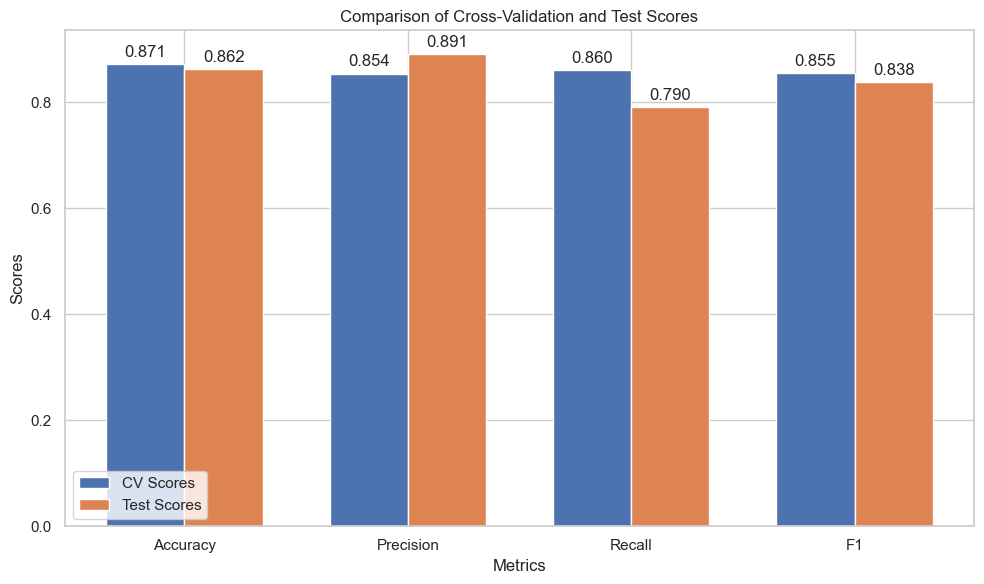

In [43]:
modelo_stacking_media_moda = joblib.load(ruta_modelos_stacking + 'stacking_media_moda.pkl')

best_model = modelo_stacking_media_moda['model']
mean_metrics = modelo_stacking_media_moda['mean_metrics']  
label_encoder = modelo_stacking_media_moda['label_encoder']  

if not hasattr(label_encoder, 'classes_'):
    label_encoder.fit(y_train) 

best_model.fit(X_train, label_encoder.transform(y_train))

y_pred = best_model.predict(X_test)

report = classification_report(
    label_encoder.transform(y_test),  # Convertimos etiquetas categóricas a numéricas
    y_pred,
    output_dict=True
)

test_accuracy = report['accuracy']
test_precision = report['1']['precision']  # Clase positiva codificada como '1'
test_recall = report['1']['recall']
test_f1 = report['1']['f1-score']

mean_train_accuracy = mean_metrics['accuracy']
mean_train_precision = mean_metrics['precision']
mean_train_recall = mean_metrics['recall']
mean_train_f1 = mean_metrics['f1']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy, mean_train_precision, mean_train_recall, mean_train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Como podemos apreciar en la gráfica, los valores de **test** incluso superan a los de **train** en `Precision`, lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Accuracy`, `Recall` y `F1` es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

### Dataset con knn-vecinos donde haya valores NA

Vamos a entrenar un modelo de **Stacking** con el dataset que hemos creado imputando los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [44]:
%%skip_if saltarse_generacion_modelos


label_encoder = LabelEncoder()


rf_pipeline = Pipeline([('preprocessor', preprocessor_knn), 
                        ('randomforest', RandomForestClassifier(random_state=semilla))])

ada_pipeline = Pipeline([('preprocessor', preprocessor_knn), 
                         ('adaboost', AdaBoostClassifier(algorithm='SAMME', random_state=semilla))])

gb_pipeline = Pipeline([('preprocessor', preprocessor_knn), 
                        ('gradientboost', GradientBoostingClassifier(random_state=semilla))])

meta_model = LogisticRegression(random_state=semilla)

stacking_model = StackingClassifier(
    estimators=[('random_forest', rf_pipeline),
                ('adaboost', ada_pipeline),
                ('gradient_boosting', gb_pipeline)],
    final_estimator=meta_model
)



mean_metrics = {}

for metric_name, scorer in scoring.items():
    scores = cross_val_score(
        estimator=stacking_model,
        X=X_train,
        y=y_train, 
        cv=10,
        scoring=scorer
    )
    mean_metrics[metric_name] = np.mean(scores)  

results = {
    "model": stacking_model,
    "mean_metrics": mean_metrics,  
    "label_encoder": label_encoder  
}

joblib.dump(results, ruta_modelos_stacking + 'stacking_knn_imputer.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

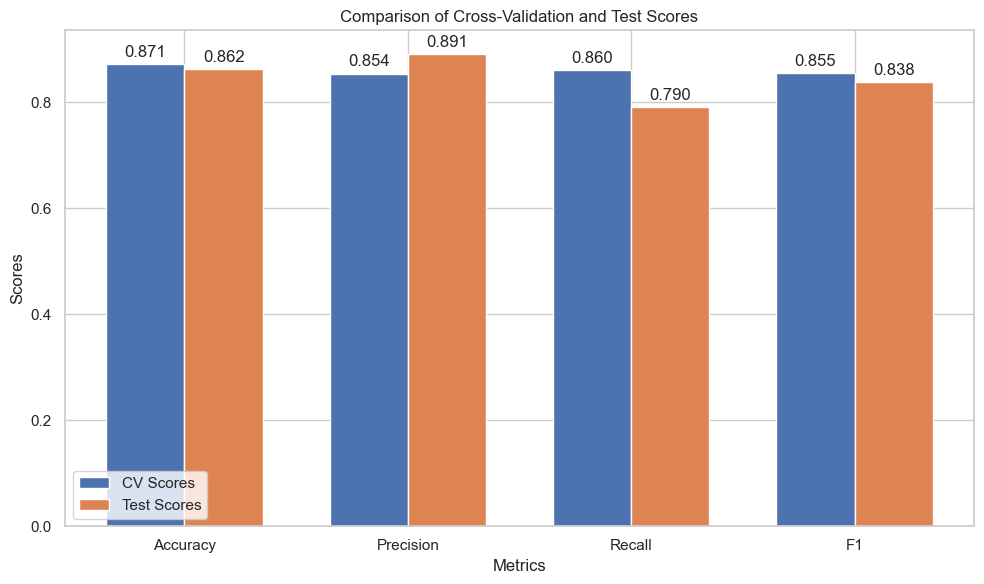

In [45]:
modelo_stacking_knn_imputer = joblib.load(ruta_modelos_stacking + 'stacking_knn_imputer.pkl')

best_model = modelo_stacking_media_moda['model']
mean_metrics = modelo_stacking_media_moda['mean_metrics']  
label_encoder = modelo_stacking_media_moda['label_encoder']  

if not hasattr(label_encoder, 'classes_'):
    label_encoder.fit(y_train) 

best_model.fit(X_train, label_encoder.transform(y_train))

y_pred = best_model.predict(X_test)

report = classification_report(
    label_encoder.transform(y_test),  # Convertimos etiquetas categóricas a numéricas
    y_pred,
    output_dict=True
)

test_accuracy = report['accuracy']
test_precision = report['1']['precision']  # Clase positiva codificada como '1'
test_recall = report['1']['recall']
test_f1 = report['1']['f1-score']

mean_train_accuracy = mean_metrics['accuracy']
mean_train_precision = mean_metrics['precision']
mean_train_recall = mean_metrics['recall']
mean_train_f1 = mean_metrics['f1']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy, mean_train_precision, mean_train_recall, mean_train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Como podemos apreciar en la gráfica, los valores de **test** incluso superan a los de **train** en algunas métricas como el `Accuracy` lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Precision`, `Recall` y `F1` entra dentro de lo esperable.

Esta mejora en el rendimiento del modelo en el conjunto de test en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

## Árbol de Decisión

Un **Árbol de Decisión** es un modelo predictivo que utiliza un árbol como estructura de representación. Cada nodo interno representa una característica (atributo), cada rama representa una decisión basada en esa característica, y cada hoja representa el resultado de la decisión.

#### Hiperparámetros de DecisionTreeClassifier

1. **`criterion`**:
   - **Descripción**: La función utilizada para medir la calidad de las divisiones en el árbol. 
     - **`gini`**: Índice de Gini, que mide la impureza de los nodos.
     - **`entropy`**: Entropía, que mide la ganancia de información al dividir los nodos.
   - **Valores con los que haremos el grid**: `['gini', 'entropy']`.

2. **`max_depth`**:
   - **Descripción**: Profundidad máxima del árbol. Limitar la profundidad ayuda a prevenir el sobreajuste, controlando la complejidad del modelo.
   - **Valores con los que haremos el grid**: `[None, 5, 10, 20, 30]`.

3. **`min_samples_split`**:
   - **Descripción**: Número mínimo de muestras necesarias para dividir un nodo en el árbol. Aumentar este valor puede ayudar a prevenir el sobreajuste.
   - **Valores con los que haremos el grid**: `[2, 5, 10]`.

4. **`min_samples_leaf`**:
   - **Descripción**: Número mínimo de muestras requeridas para estar en una hoja. Establecer este parámetro puede evitar que el árbol crezca demasiado y se adapte demasiado a los datos.
   - **Valores con los que haremos el grid**: `[1, 2, 5]`.

5. **`max_features`**:
   - **Descripción**: Número máximo de características a considerar al dividir un nodo. Seleccionar un valor adecuado puede mejorar la precisión y reducir el sobreajuste.
   - **Valores con los que haremos el grid**: `['sqrt', 'log2']`.

6. **`splitter`**:
   - **Descripción**: Estrategia utilizada para dividir los nodos. 
     - **`best`**: Elige la mejor división posible.
     - **`random`**: Elige una división aleatoria.
   - **Valores con los que haremos el grid**: `['best', 'random']`.

7. **`max_leaf_nodes`**:
   - **Descripción**: Número máximo de hojas en el árbol. Restringir el número de hojas puede evitar que el árbol sea demasiado complejo.
   - **Valores con los que haremos el grid**: `[None, 10, 20, 50]`.




In [46]:
param_grid_arbol = {
    'arbol__criterion': ['gini', 'entropy'],
    'arbol__max_depth': [None, 5, 10, 20, 30],
    'arbol__min_samples_split': [2, 5, 10],
    'arbol__min_samples_leaf': [1, 2, 5],
    'arbol__max_features': ['sqrt', 'log2'],
    'arbol__splitter': ['best', 'random'],
    'arbol__max_leaf_nodes': [None, 10, 20, 50]
}

### Dataset sin las filas con NA

Validamos el modelo de **Árbol de Decisión** con el dataset que hemos creado sin las filas con valores nulos.

In [47]:
%%skip_if saltarse_generacion_modelos


arbol_pipeline = Pipeline([
    ('preprocessor', preprocessor_sin_NA),
    ('arbol', DecisionTreeClassifier(random_state=semilla))
])

grid_search = GridSearchCV(
    estimator=arbol_pipeline, 
    param_grid=param_grid_arbol, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=2)

grid_search.fit(X_train_sin_na, y_train_sin_na)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_arbol + 'grid_search_arbol_sin_filas_na.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'arbol__criterion': 'gini', 'arbol__max_depth': None, 'arbol__max_features': 'log2', 'arbol__max_leaf_nodes': 10, 'arbol__min_samples_leaf': 1, 'arbol__min_samples_split': 10, 'arbol__splitter': 'random'}
Accuracy: 0.848
Precision: 0.824
Recall: 0.853
F1: 0.834
Accuracy: 0.840
Precision: 0.831
Recall: 0.817
F1: 0.824


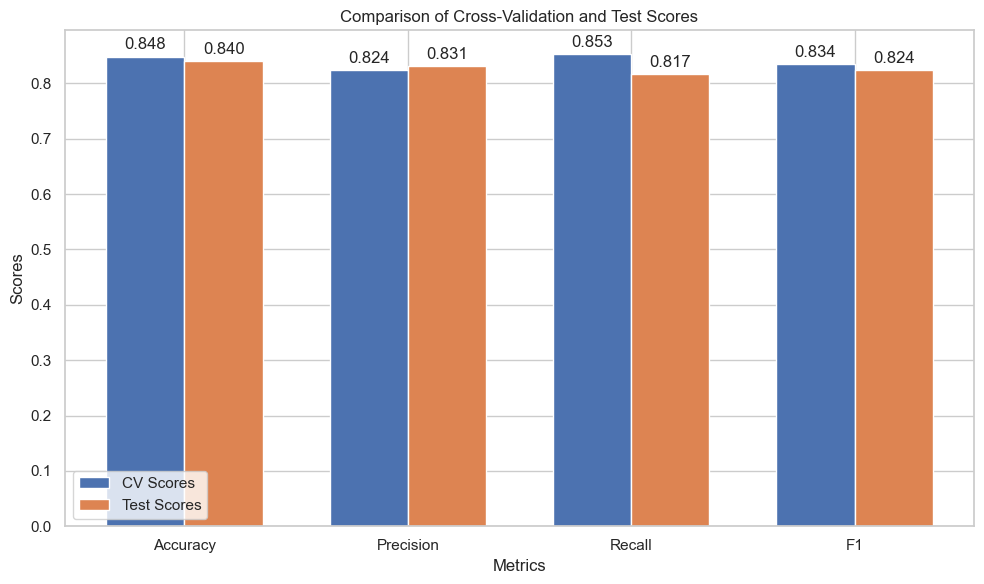

In [48]:
grid_search = joblib.load(ruta_modelos_arbol + 'grid_search_arbol_sin_filas_na.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sin_na)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

print(f"Accuracy: {mean_train_accuracy.mean():.3f}")
print(f"Precision: {mean_train_precision.mean():.3f}")
print(f"Recall: {mean_train_recall.mean():.3f}")
print(f"F1: {mean_train_scores.mean():.3f}")

report = classification_report(y_test_sin_na, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1: {test_f1:.3f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo **Árbol de Decisión** con el conjunto de datos sin valores nulos son:

- `arbol__criterion = 'gini'`
- `arbol__max_depth = None`
- `arbol__max_features = 'log2'`
- `arbol__max_leaf_nodes = 10`
- `arbol__min_samples_leaf = 1`
- `arbol__min_samples_split = 10`
- `arbol__splitter = 'random'`

Como podemos apreciar en la gráfica, los valores de **test** incluso superan a los de **train** en una métrica como el `Precision`, lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Accuracy`, `Recall` y `F1` es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de **test** en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.


### Dataset con media y moda donde haya valores NA

Validamos el modelo de **Árbol de Decisión** con el dataset que hemos creado sin las filas con valores nulos.

In [49]:
%%skip_if saltarse_generacion_modelos


arbol_pipeline = Pipeline([
    ('preprocessor', preprocessor_media_moda),
    ('arbol', DecisionTreeClassifier(random_state=semilla))
])

grid_search = GridSearchCV(
    estimator=arbol_pipeline, 
    param_grid=param_grid_arbol, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=2)

grid_search.fit(X_train, y_train)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_arbol + 'grid_search_arbol_moda_media.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'arbol__criterion': 'gini', 'arbol__max_depth': 10, 'arbol__max_features': 'log2', 'arbol__max_leaf_nodes': None, 'arbol__min_samples_leaf': 5, 'arbol__min_samples_split': 2, 'arbol__splitter': 'random'}
Accuracy: 0.835
Precision: 0.810
Recall: 0.829
F1: 0.814
Accuracy: 0.855
Precision: 0.862
Recall: 0.806
F1: 0.833


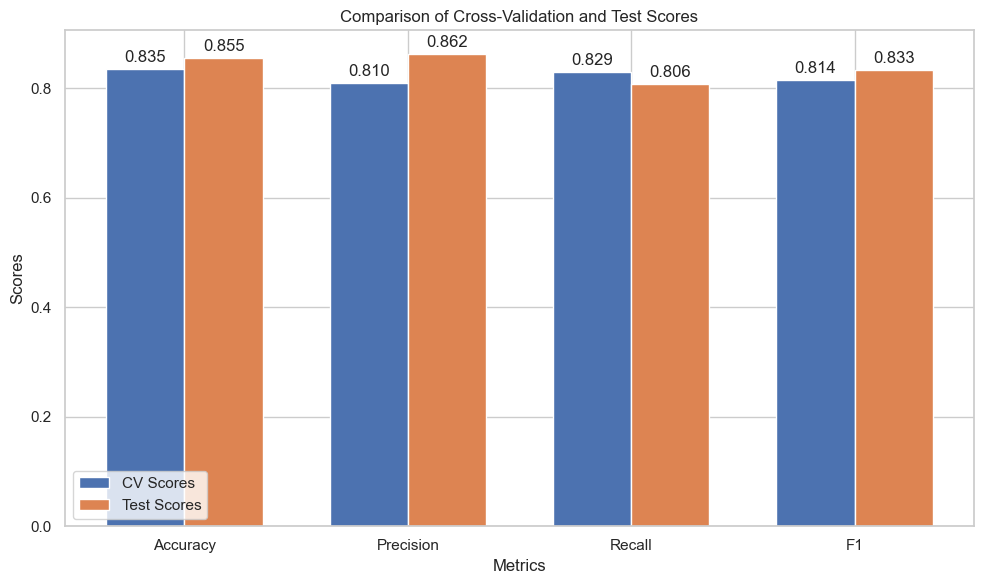

In [50]:
grid_search = joblib.load(ruta_modelos_arbol + 'grid_search_arbol_moda_media.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

print(f"Accuracy: {mean_train_accuracy.mean():.3f}")
print(f"Precision: {mean_train_precision.mean():.3f}")
print(f"Recall: {mean_train_recall.mean():.3f}")
print(f"F1: {mean_train_scores.mean():.3f}")

report = classification_report(y_test, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1: {test_f1:.3f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo **Árbol de Decisión** con el conjunto de datos sin valores nulos son:

- `arbol__criterion = 'gini'`
- `arbol__max_depth = 10`
- `arbol__max_features = 'log2'`
- `arbol__max_leaf_nodes = None`
- `arbol__min_samples_leaf = 5`
- `arbol__min_samples_split = 2`
- `arbol__splitter = 'random'`

Como podemos apreciar en la gráfica, los valores de **test** incluso superan a los de **train** en una métrica como `Precision`, `Accuracy` y `F1` lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Recall` es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de **test** en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

### Dataset con knn-vecinos donde haya valores NA

Vamos a entrenar un modelo de **Árbol de Decisión** con el dataset que hemos creado imputando los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [51]:
%%skip_if saltarse_generacion_modelos


arbol_pipeline = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('arbol', DecisionTreeClassifier(random_state=semilla))
])

grid_search = GridSearchCV(
    estimator=arbol_pipeline, 
    param_grid=param_grid_arbol, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=2)

grid_search.fit(X_train, y_train)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_arbol + 'grid_search_arbol_knn_imputer.pkl')


#### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'arbol__criterion': 'gini', 'arbol__max_depth': 10, 'arbol__max_features': 'log2', 'arbol__max_leaf_nodes': None, 'arbol__min_samples_leaf': 5, 'arbol__min_samples_split': 2, 'arbol__splitter': 'random'}
Accuracy: 0.835
Precision: 0.809
Recall: 0.830
F1: 0.814
Accuracy: 0.855
Precision: 0.862
Recall: 0.806
F1: 0.833


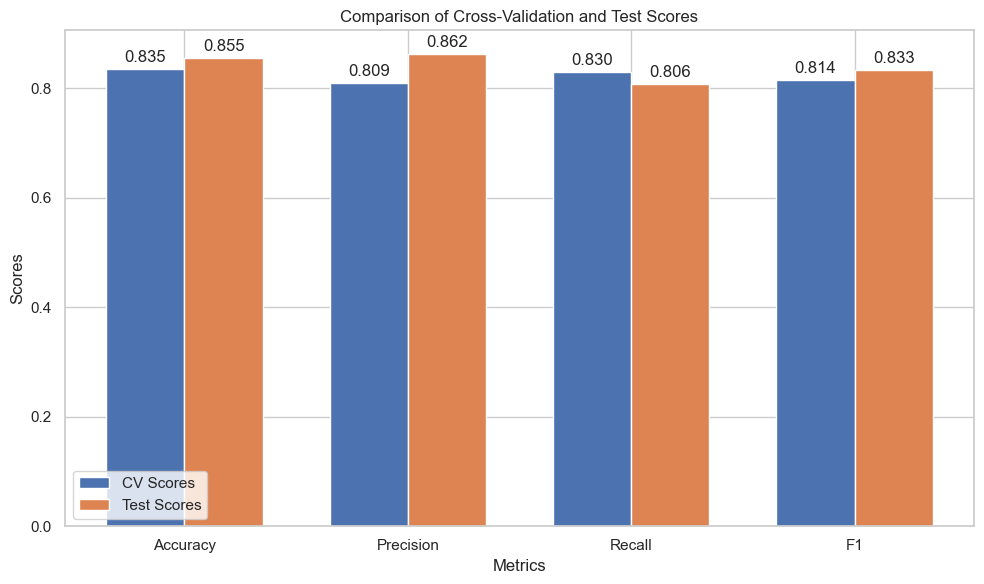

In [52]:
grid_search = joblib.load(ruta_modelos_arbol + 'grid_search_arbol_knn_imputer.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

print(f"Accuracy: {mean_train_accuracy.mean():.3f}")
print(f"Precision: {mean_train_precision.mean():.3f}")
print(f"Recall: {mean_train_recall.mean():.3f}")
print(f"F1: {mean_train_scores.mean():.3f}")

report = classification_report(y_test, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['SI']['precision']
test_recall = report['SI']['recall']
test_f1 = report['SI']['f1-score']

print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1: {test_f1:.3f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Los mejores hiperparámetros encontrados para el modelo **Árbol de Decisión** con el conjunto de datos sin valores nulos son:

- `arbol__criterion = 'gini'`
- `arbol__max_depth = 10`
- `arbol__max_features = 'log2'`
- `arbol__max_leaf_nodes = None`
- `arbol__min_samples_leaf = 5`
- `arbol__min_samples_split = 2`
- `arbol__splitter = 'random'`

Como podemos apreciar en la gráfica, los valores de **test** incluso superan a los de **train** en una métrica como `Precision`, `Accuracy` y `F1` lo que indica que no hay **overfitting** ni tampoco **underfitting** porque la diferencia entre los valores de **train** y **test** en `Recall` es mínima.

Esta mejora en el rendimiento del modelo en el conjunto de **test** en comparación con la validación cruzada puede ser atribuida a la variabilidad en los datos de entrenamiento y prueba, lo que puede llevar a resultados ligeramente diferentes. Sin embargo, la diferencia es mínima y no indica un problema de overfitting o underfitting.

## K-Vecinos más cercanos
El algoritmo de **K-Vecinos más cercanos (K-Nearest Neighbors, KNN)** es un método de aprendizaje supervisado que se utiliza para clasificación y regresión. En KNN, las instancias se clasifican en función de las instancias vecinas más cercanas en el espacio de características. KNN es muy sensible a la escala de los datos, por lo que se recomienda normalizar o estandarizar las características antes de aplicar este algoritmo.

### Hiperparámetros de KNeighborsClassifier

1. **`n_neighbors`**:
   - **Descripción**: Es el número de vecinos a considerar al realizar la clasificación de una instancia. Un valor bajo puede llevar a un **sobreajuste (overfitting)**, ya que el modelo se adapta demasiado a las pequeñas variaciones en los datos de entrenamiento. Un valor alto puede llevar a un **subajuste (underfitting)**, ya que el modelo no captura bien la estructura de los datos.
   - **Valores con los que haremos el grid**: `[3, 5, 7, 9, 11]`.

2. **`weights`**:
   - **Descripción**: Define la forma en que se ponderan los vecinos. Puede tomar dos valores:
     - `'uniform'`: Todos los vecinos tienen el mismo peso.
     - `'distance'`: Los vecinos más cercanos tienen más peso, ya que su distancia al punto de predicción es menor.
   - **Valores con los que haremos el grid**: `['uniform', 'distance']`.

3. **`algorithm`**:
   - **Descripción**: Especifica el algoritmo utilizado para calcular los vecinos más cercanos. Hay varias opciones, dependiendo de la eficiencia en diferentes tipos de datos:
     - `'auto'`: El algoritmo se selecciona automáticamente según los datos.
     - `'ball_tree'`: Utiliza un árbol de bolas, que es eficiente para grandes conjuntos de datos con muchas características.
     - `'kd_tree'`: Utiliza un árbol k-dimensional, más eficiente cuando hay menos dimensiones.
     - `'brute'`: Busca exhaustivamente a través de todos los puntos.
   - **Valores con los que haremos el grid**: `['auto', 'ball_tree', 'kd_tree', 'brute']`.

4. **`leaf_size`**:
   - **Descripción**: Es el tamaño de la hoja utilizado por los algoritmos de `ball_tree` y `kd_tree`. Este parámetro puede afectar tanto la velocidad de entrenamiento como la precisión del modelo. Un valor mayor generalmente hace que la construcción del árbol sea más rápida, pero la búsqueda de los vecinos será más lenta.
   - **Valores con los que haremos el grid**: `[10, 20, 30, 40, 50]`.

5. **`p`**:
   - **Descripción**: Controla la métrica de distancia utilizada en el algoritmo. Dependiendo del valor de `p`, se utilizará una métrica de distancia diferente:
     - Si `p = 1`, se utiliza la **distancia de Manhattan**.
     - Si `p = 2`, se utiliza la **distancia Euclidiana**.
   - **Valores con los que haremos el grid**: `[1, 2]`.

In [53]:
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 20, 30, 40, 50],
    'knn__p': [1, 2]
}

Tenemos que modificar el scoring para que funciona con el algoritmo de KNN.

In [54]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label=1),  # 1 es la clase positiva
    'recall': make_scorer(recall_score, pos_label=1),        # 1 es la clase positiva
    'f1': make_scorer(f1_score, pos_label=1)                 # 1 es la clase positiva
}

### Dataset sin las filas con NA

Vamos a entrenar un modelo de **K-Vecinos más cercanos** con el dataset que hemos creado sin las filas con valores nulos.

In [55]:
%%skip_if saltarse_generacion_modelos




label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sin_na)  # Convierte 'NO', 'SI' en 0, 1

# Crear el pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor_sin_NA),  # Aquí está tu preprocesador (transformaciones necesarias)
    ('knn', KNeighborsClassifier())         # Modelo KNN
])

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,  # Asegúrate de definir param_grid_knn
    cv=10,                      # Número de divisiones para validación cruzada
    scoring=scoring,            # Asegúrate de definir 'scoring' correctamente
    refit='f1',                 # Métrica principal para ajustar el mejor modelo
    verbose=2                   # Nivel de salida para diagnóstico
)

# Ajustar el modelo con las etiquetas codificadas
grid_search.fit(X_train_sin_na, y_train_encoded)

# Guardar el modelo entrenado
joblib.dump(grid_search, ruta_modelos_knn + 'grid_search_knn_sin_filas_na.pkl')

### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.664
Precision: 0.667
Recall: 0.524
F1: 0.579
Accuracy: 0.634
Precision: 0.620
Recall: 0.517
F1: 0.564


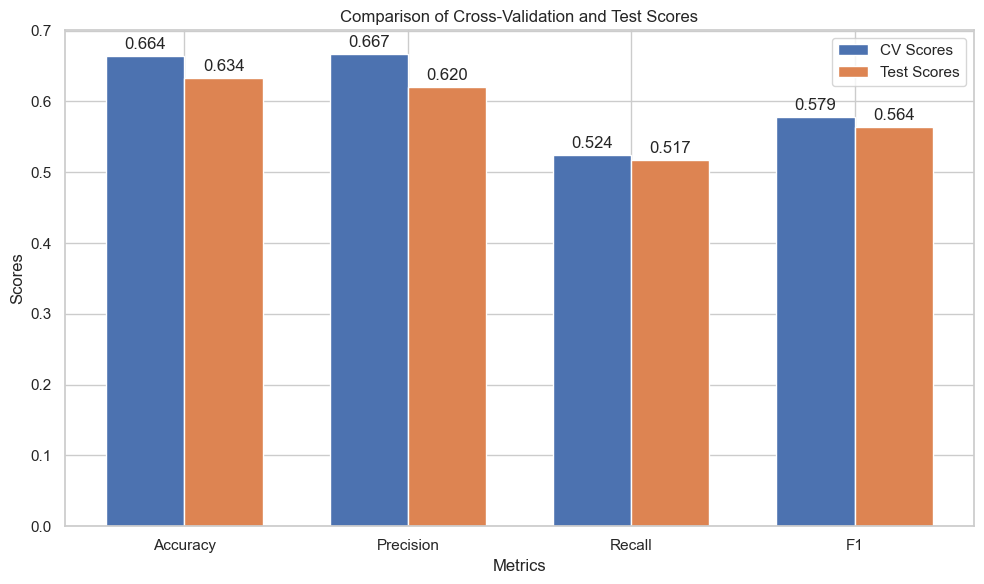

In [56]:
grid_search = joblib.load(ruta_modelos_knn + 'grid_search_knn_sin_filas_na.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sin_na)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

print(f"Accuracy: {mean_train_accuracy.mean():.3f}")
print(f"Precision: {mean_train_precision.mean():.3f}")
print(f"Recall: {mean_train_recall.mean():.3f}")
print(f"F1: {mean_train_scores.mean():.3f}")

#Transforma todos los SI a 1 y los NO a 0
y_test_sin_na_encoded = y_test_sin_na.apply(lambda x: 1 if x == 'SI' else 0)

report = classification_report(y_test_sin_na_encoded, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['1']['precision']
test_recall = report['1']['recall']
test_f1 = report['1']['f1-score']

print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1: {test_f1:.3f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Los mejores hiperparámetros encontrados para el modelo **K-Vecinos más cercanos (KNN)** con el conjunto de datos sin valores nulos son:

- `knn__algorithm = 'auto'`
- `knn__leaf_size = 10`
- `knn__n_neighbors = 7`
- `knn__p = 1`
- `knn__weights = 'distance'`

Como podemos apreciar en la gráfica, los valores de **test** son más bajos que los de **train** en todas las métricas, sin embargo, la diferencia es mínima y no indica un problema de **overfitting** o **underfitting**.


### Dataset con media y moda donde haya valores NA

Vamos a entrenar un modelo de **K-Vecinos más cercanos** con el dataset que hemos creado imputando los valores nulos numéricos con la media de la columna correspondiente y los valores nulos categóricos con la moda de la columna.

In [57]:
%%skip_if saltarse_generacion_modelos

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convierte 'NO', 'SI' en 0, 1

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor_media_moda),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid=param_grid_knn, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=2)

grid_search.fit(X_train, y_train_encoded)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_knn + 'grid_search_knn_moda_media.pkl')

### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.655
Precision: 0.655
Recall: 0.504
F1: 0.563
Accuracy: 0.652
Precision: 0.667
Recall: 0.452
F1: 0.538


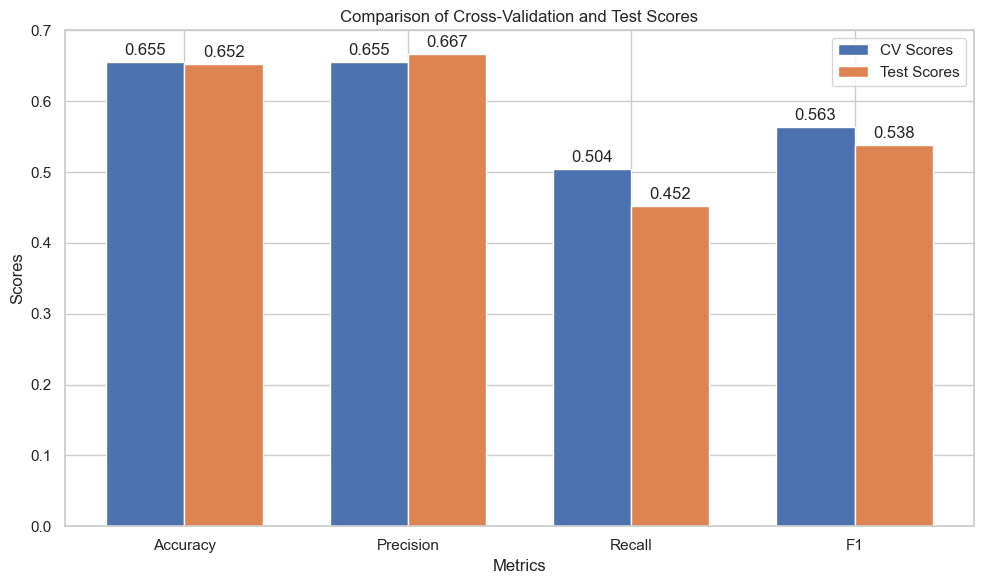

In [58]:
grid_search = joblib.load(ruta_modelos_knn + 'grid_search_knn_moda_media.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

print(f"Accuracy: {mean_train_accuracy.mean():.3f}")
print(f"Precision: {mean_train_precision.mean():.3f}")
print(f"Recall: {mean_train_recall.mean():.3f}")
print(f"F1: {mean_train_scores.mean():.3f}")

y_test_encoded = y_test.apply(lambda x: 1 if x == 'SI' else 0)

report = classification_report(y_test_encoded, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['1']['precision']
test_recall = report['1']['recall']
test_f1 = report['1']['f1-score']

print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1: {test_f1:.3f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Los mejores hiperparámetros encontrados para el modelo **K-Vecinos más cercanos (KNN)** con el conjunto de datos sin valores nulos son:

- `knn__algorithm = 'auto'`
- `knn__leaf_size = 10`
- `knn__n_neighbors = 7`
- `knn__p = 1`
- `knn__weights = 'distance'`

Como podemos apreciar en la gráfica, los valores de **test** son más bajos que los de **train** en todas las métricas menos en `Precision`, como  la diferencia es pequeña y no indica un problema de **overfitting** o **underfitting**.

### Dataset con knn-vecinos donde haya valores NA

Vamos a entrenar un modelo de **K-Vecinos más cercanos** con el dataset que hemos creado imputando los valores nulos utilizando el algoritmo KNN (K-Vecinos más cercanos) con k=5.

In [59]:
%%skip_if saltarse_generacion_modelos

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convierte 'NO', 'SI' en 0, 1

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid=param_grid_knn, 
    cv=10, 
    scoring=scoring,
    refit='f1', 
    verbose=2)

grid_search.fit(X_train, y_train_encoded)

# Guardar el grid search
joblib.dump(grid_search, ruta_modelos_knn + 'grid_search_knn_knn_imputer.pkl')

### Evaluación de Overfitting y Underfitting

Vamos a evaluar si el modelo está sufriendo de **overfitting** o **underfitting**. Para ello, vamos a comparar las métricas de rendimiento obtenidas la crosvalidación y en el conjunto de test.

Mejores parámetros encontrados:
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.656
Precision: 0.658
Recall: 0.505
F1: 0.565
Accuracy: 0.659
Precision: 0.674
Recall: 0.468
F1: 0.552


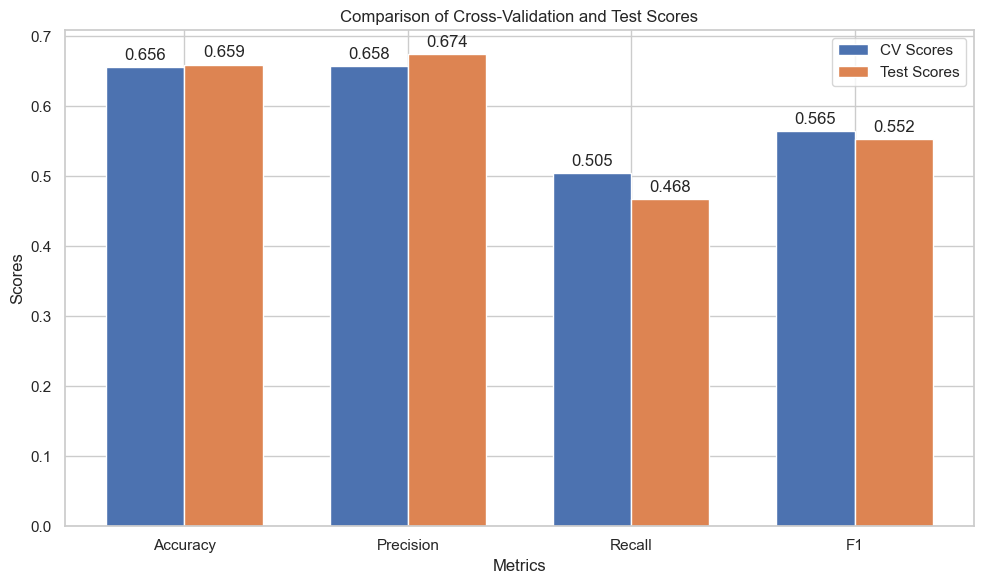

In [60]:
grid_search = joblib.load(ruta_modelos_knn + 'grid_search_knn_knn_imputer.pkl')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejores parámetros encontrados:\n{grid_search.best_params_}")

cv_results = grid_search.cv_results_

mean_train_scores = cv_results['mean_test_f1'] 
mean_train_accuracy = cv_results['mean_test_accuracy']
mean_train_precision = cv_results['mean_test_precision']
mean_train_recall = cv_results['mean_test_recall']

print(f"Accuracy: {mean_train_accuracy.mean():.3f}")
print(f"Precision: {mean_train_precision.mean():.3f}")
print(f"Recall: {mean_train_recall.mean():.3f}")
print(f"F1: {mean_train_scores.mean():.3f}")

y_test_encoded = y_test.apply(lambda x: 1 if x == 'SI' else 0)

report = classification_report(y_test_encoded, y_pred, output_dict=True)

test_accuracy = report['accuracy']
test_precision = report['1']['precision']
test_recall = report['1']['recall']
test_f1 = report['1']['f1-score']

print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1: {test_f1:.3f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [mean_train_accuracy.mean(), mean_train_precision.mean(), mean_train_recall.mean(), mean_train_scores.mean()]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # Para la posición de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='CV Scores')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Scores')

# Añadir etiquetas y título
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Cross-Validation and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir los valores en las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Los mejores hiperparámetros encontrados para el modelo **K-Vecinos más cercanos (KNN)** con el conjunto de datos sin valores nulos son:

- `knn__algorithm = 'auto'`
- `knn__leaf_size = 10`
- `knn__n_neighbors = 7`
- `knn__p = 1`
- `knn__weights = 'distance'`

Como podemos apreciar en la gráfica, los valores de **test** en algunas métricas como `Precision` o `Accuracy` son más altos que los de **train**,en cambio es más baja em `Recall` y `F1`. Viendo la gráfica consideramos que la diferencia es mínima y no indica un problema de **overfitting** o **underfitting**.

# Evaluación de los modelos





Como hemos observado en ningún modelo hay **overfitting** ni **underfitting** porque la diferencia entre los valores de **train** y **test** es mínima. A pesar de la pequeña cantidad que reprentaba las instancias con valores nulos (`5'43%`) hemos obtenido distintos resultados en los modelos, en algunos mejoraban los resultados de los modelos sin las instancias NA. Ahora vamos a plantear la forma en la cuál hemos escogido las métricas y al final habrá una tabla con los resultados de los modelos donde discutiremos cuál es el mejor modelo dependiendo de distintas situaciones.

## Matriz de confusión de los modelos

Nos vamos a fijarnos únicamente en los valores de la clase positiva, es decir, en los valores de la columna `objetivo` es concedido. Porque vamos a planternos dos escenarios para el banco:

1. **Falso Positivo**: El banco concede un préstamo a un cliente que no va a poder devolverlo.
2. **Falso Negativo**: El banco no concede un préstamo a un cliente que sí podría devolverlo.

Entonces para ello nos tenemos que fijar para el primer caso en la métrica de `Precision` y para el segundo caso en la métrica de `Recall` para la variable positiva en este caso.

### AdaBoost

Aplicamos el modelo de AdaBoost con los hiperparámetros encontrados en el dataset sin valores nulos y obtenemos las siguientes métricas:

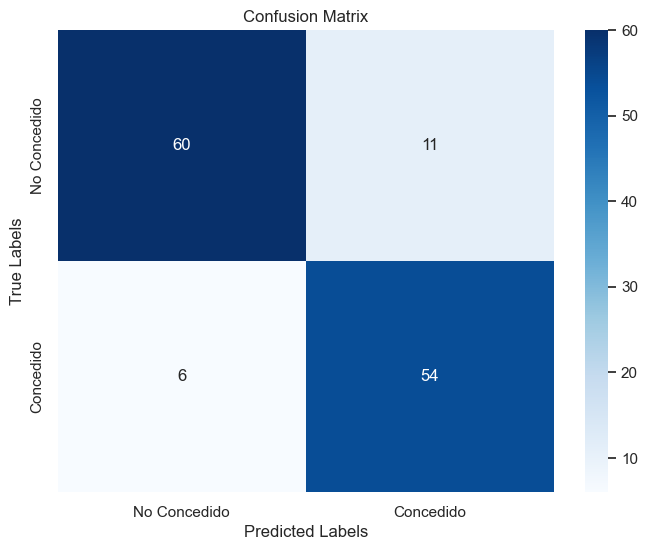

Reporte de Clasificación en conjunto de prueba sin NA:
              precision    recall  f1-score   support

          NO       0.91      0.85      0.88        71
          SI       0.83      0.90      0.86        60

    accuracy                           0.87       131
   macro avg       0.87      0.87      0.87       131
weighted avg       0.87      0.87      0.87       131



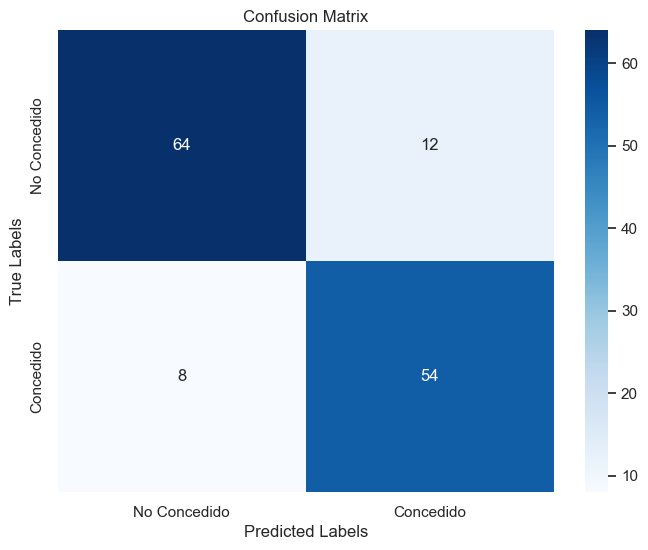

Reporte de Clasificación en conjunto de prueba con media y moda:
              precision    recall  f1-score   support

          NO       0.89      0.84      0.86        76
          SI       0.82      0.87      0.84        62

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138



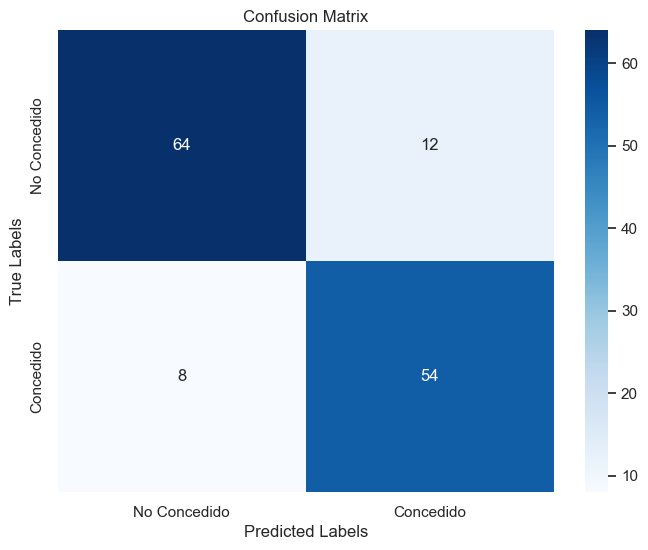

Reporte de Clasificación en conjunto de prueba con KNN imputer:
              precision    recall  f1-score   support

          NO       0.89      0.84      0.86        76
          SI       0.82      0.87      0.84        62

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138



In [61]:
# Caragmos el modelo adaboost

modelo_adaboost_na = joblib.load(ruta_modelos_adaboost + 'grid_search_adaboost_sin_filas_na.pkl')
modelo_adaboost_mm = joblib.load(ruta_modelos_adaboost + 'grid_search_adaboost_moda_media.pkl')
modelo_adaboost_knn = joblib.load(ruta_modelos_adaboost + 'grid_search_adaboost_knn_imputer.pkl')

best_model_na = modelo_adaboost_na.best_estimator_
best_model_mm = modelo_adaboost_mm.best_estimator_
best_model_knn = modelo_adaboost_knn.best_estimator_

y_pred_na = best_model_na.predict(X_test_sin_na)
y_pred_mm = best_model_mm.predict(X_test)
y_pred_knn = best_model_knn.predict(X_test)


# Matriz de confusión
cm = confusion_matrix(y_test_sin_na, y_pred_na)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba sin NA:")
print(classification_report(y_test_sin_na, y_pred_na))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba con media y moda:")
print(classification_report(y_test, y_pred_mm))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba con KNN imputer:")
print(classification_report(y_test, y_pred_knn))



### Random Forest

Aplicamos el modelo de Random Forest con los hiperparámetros encontrados en el dataset sin valores nulos y obtenemos las siguientes métricas:

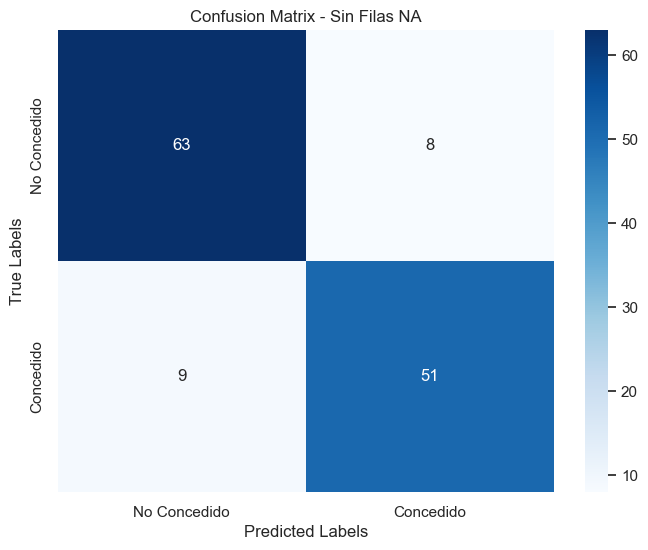

Reporte de Clasificación en conjunto de prueba sin NA:
              precision    recall  f1-score   support

          NO       0.88      0.89      0.88        71
          SI       0.86      0.85      0.86        60

    accuracy                           0.87       131
   macro avg       0.87      0.87      0.87       131
weighted avg       0.87      0.87      0.87       131



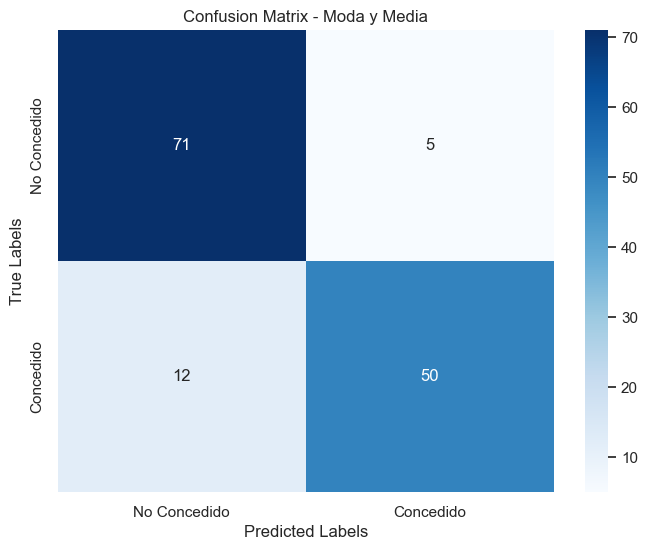

Reporte de Clasificación en conjunto de prueba con media y moda:
              precision    recall  f1-score   support

          NO       0.86      0.93      0.89        76
          SI       0.91      0.81      0.85        62

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138



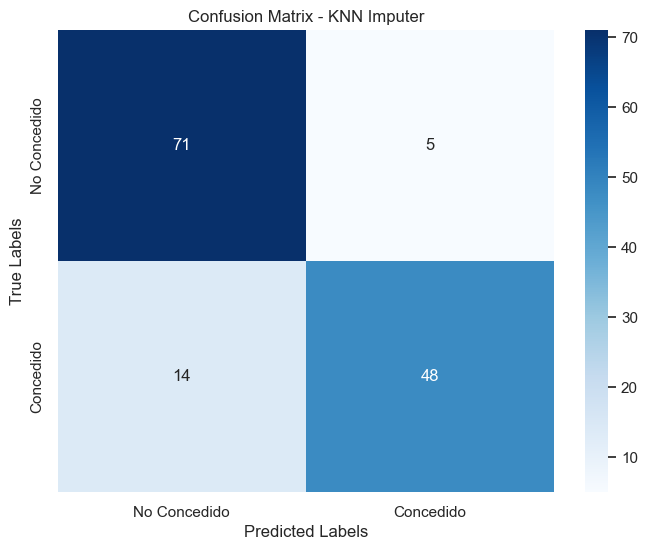

Reporte de Clasificación en conjunto de prueba con KNN imputer:
              precision    recall  f1-score   support

          NO       0.84      0.93      0.88        76
          SI       0.91      0.77      0.83        62

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138



In [62]:
# Cargamos los modelos Random Forest
modelo_rf_na = joblib.load(ruta_modelos_rf + 'grid_search_rf_sin_filas_na.pkl')
modelo_rf_mm = joblib.load(ruta_modelos_rf + 'grid_search_rf_moda_media.pkl')
modelo_rf_knn = joblib.load(ruta_modelos_rf + 'grid_search_rf_knn_imputer.pkl')

# Obtenemos los mejores modelos
best_model_na = modelo_rf_na.best_estimator_
best_model_mm = modelo_rf_mm.best_estimator_
best_model_knn = modelo_rf_knn.best_estimator_

# Predicciones
y_pred_na = best_model_na.predict(X_test_sin_na)
y_pred_mm = best_model_mm.predict(X_test)
y_pred_knn = best_model_knn.predict(X_test)

# Evaluaciones para el modelo sin filas NA
cm = confusion_matrix(y_test_sin_na, y_pred_na)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Sin Filas NA')
plt.show()

print("Reporte de Clasificación en conjunto de prueba sin NA:")
print(classification_report(y_test_sin_na, y_pred_na))

# Evaluaciones para el modelo con moda y media
cm = confusion_matrix(y_test, y_pred_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Moda y Media')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con media y moda:")
print(classification_report(y_test, y_pred_mm))

# Evaluaciones para el modelo con KNN Imputer
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - KNN Imputer')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con KNN imputer:")
print(classification_report(y_test, y_pred_knn))


### Stacking

Aplicamos el modelo de Stacking modelado en el dataset sin valores nulos y obtenemos las siguientes métricas:

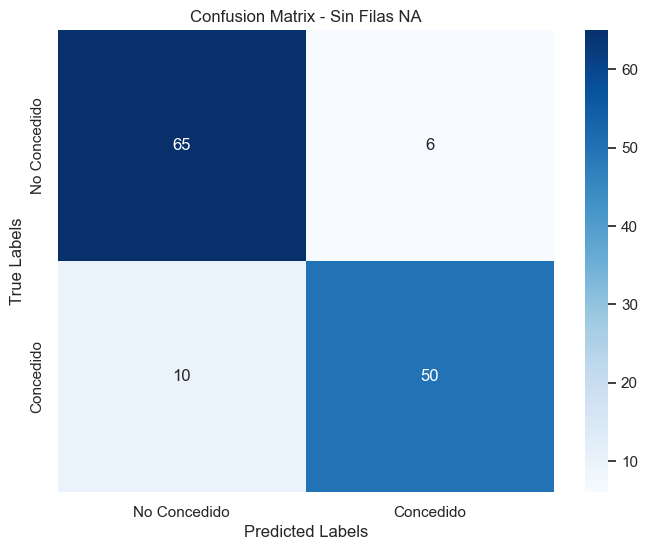

Reporte de Clasificación en conjunto de prueba sin NA:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        71
           1       0.89      0.83      0.86        60

    accuracy                           0.88       131
   macro avg       0.88      0.87      0.88       131
weighted avg       0.88      0.88      0.88       131



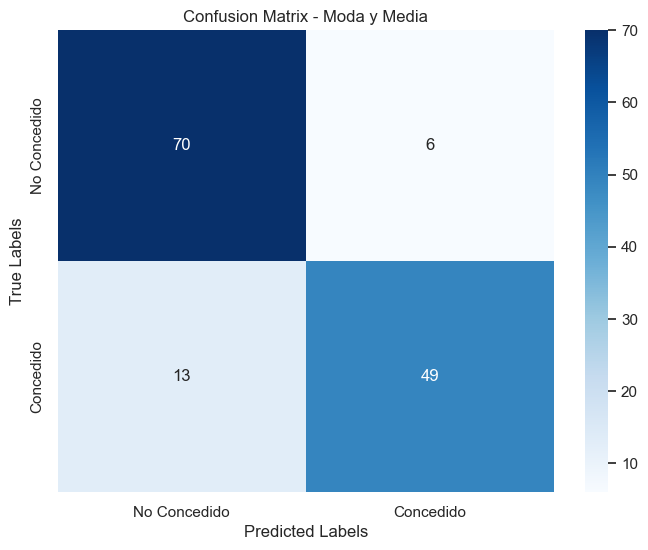

Reporte de Clasificación en conjunto de prueba con media y moda:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        76
           1       0.89      0.79      0.84        62

    accuracy                           0.86       138
   macro avg       0.87      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138



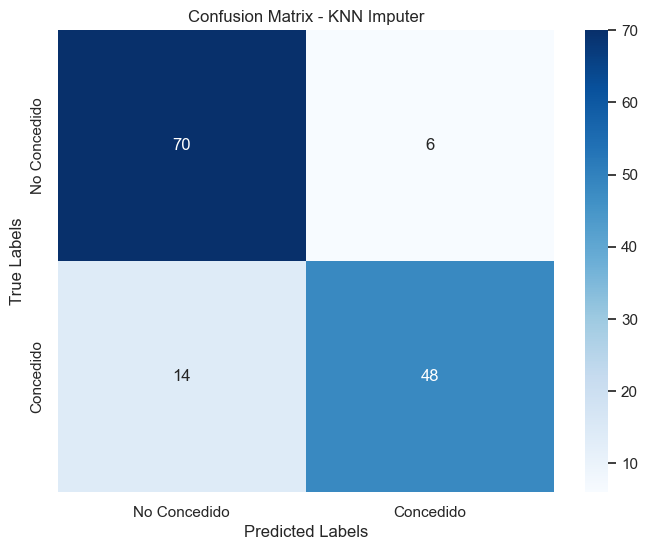

Reporte de Clasificación en conjunto de prueba con KNN imputer:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        76
           1       0.89      0.77      0.83        62

    accuracy                           0.86       138
   macro avg       0.86      0.85      0.85       138
weighted avg       0.86      0.86      0.85       138



In [63]:
# Cargamos los modelos Stacking
modelo_stacking_na = joblib.load(ruta_modelos_stacking + 'stacking_sin_filas.pkl')
modelo_stacking_mm = joblib.load(ruta_modelos_stacking + 'stacking_media_moda.pkl')
modelo_stacking_knn = joblib.load(ruta_modelos_stacking + 'stacking_knn_imputer.pkl')

# Obtenemos los mejores modelos
best_model_na = modelo_stacking_na['model']
best_model_mm = modelo_stacking_mm['model']
best_model_knn = modelo_stacking_knn['model']

# Aseguramos que el label encoder esté entrenado
if not hasattr(label_encoder, 'classes_'):
    label_encoder.fit(y_train_sin_na)

# Entrenamos los modelos (en caso necesario)
best_model_na.fit(X_train_sin_na, label_encoder.transform(y_train_sin_na))
best_model_mm.fit(X_train, label_encoder.transform(y_train))
best_model_knn.fit(X_train, label_encoder.transform(y_train))

# Predicciones
y_pred_na = best_model_na.predict(X_test_sin_na)
y_pred_mm = best_model_mm.predict(X_test)
y_pred_knn = best_model_knn.predict(X_test)

# Evaluaciones para el modelo sin filas NA
cm = confusion_matrix(label_encoder.transform(y_test_sin_na), y_pred_na)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Sin Filas NA')
plt.show()

print("Reporte de Clasificación en conjunto de prueba sin NA:")
print(classification_report(label_encoder.transform(y_test_sin_na), y_pred_na))

# Evaluaciones para el modelo con moda y media
cm = confusion_matrix(label_encoder.transform(y_test), y_pred_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Moda y Media')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con media y moda:")
print(classification_report(label_encoder.transform(y_test), y_pred_mm))

# Evaluaciones para el modelo con KNN Imputer
cm = confusion_matrix(label_encoder.transform(y_test), y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - KNN Imputer')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con KNN imputer:")
print(classification_report(label_encoder.transform(y_test), y_pred_knn))



### Arbol de Decisión

Aplicamos el modelo de Árbol de Decisión con los hiperparámetros encontrados en el dataset sin valores nulos y obtenemos las siguientes métricas:

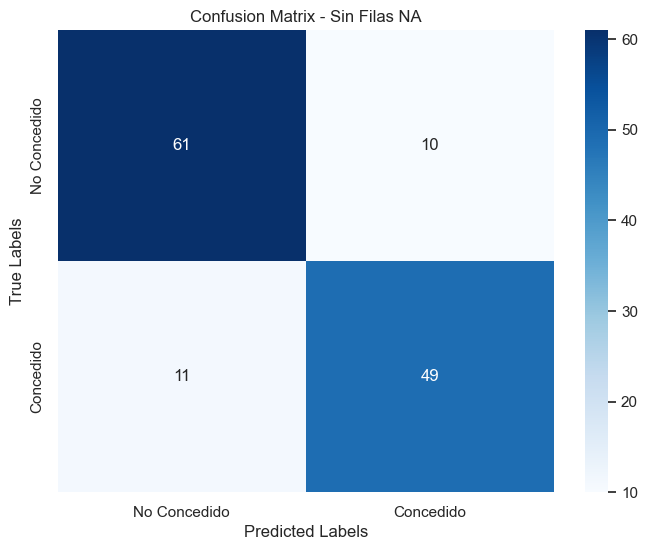

Reporte de Clasificación en conjunto de prueba sin NA:
              precision    recall  f1-score   support

          NO       0.85      0.86      0.85        71
          SI       0.83      0.82      0.82        60

    accuracy                           0.84       131
   macro avg       0.84      0.84      0.84       131
weighted avg       0.84      0.84      0.84       131



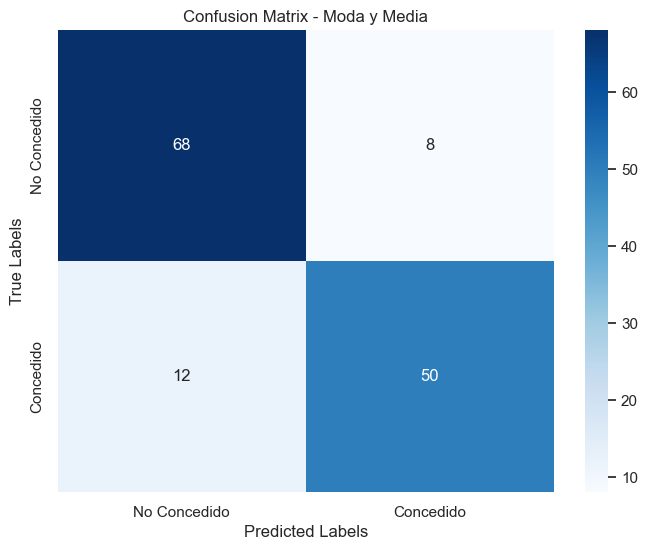

Reporte de Clasificación en conjunto de prueba con media y moda:
              precision    recall  f1-score   support

          NO       0.85      0.89      0.87        76
          SI       0.86      0.81      0.83        62

    accuracy                           0.86       138
   macro avg       0.86      0.85      0.85       138
weighted avg       0.86      0.86      0.85       138



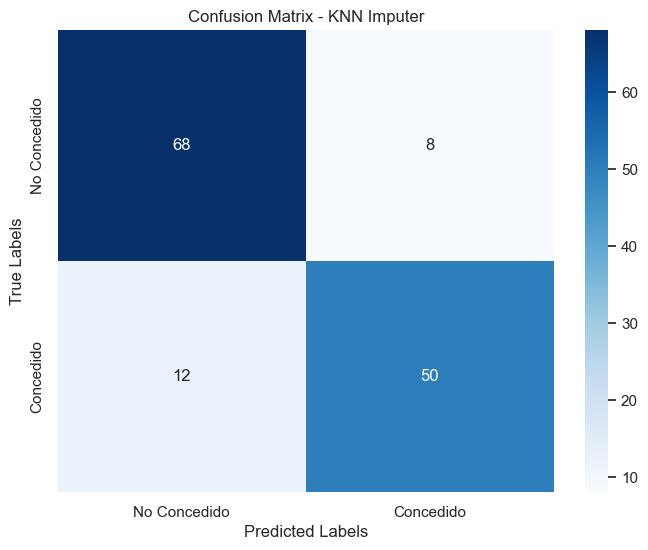

Reporte de Clasificación en conjunto de prueba con KNN imputer:
              precision    recall  f1-score   support

          NO       0.85      0.89      0.87        76
          SI       0.86      0.81      0.83        62

    accuracy                           0.86       138
   macro avg       0.86      0.85      0.85       138
weighted avg       0.86      0.86      0.85       138



In [64]:
# Cargamos los modelos de Árbol de Decisión
modelo_arbol_na = joblib.load(ruta_modelos_arbol + 'grid_search_arbol_sin_filas_na.pkl')
modelo_arbol_mm = joblib.load(ruta_modelos_arbol + 'grid_search_arbol_moda_media.pkl')
modelo_arbol_knn = joblib.load(ruta_modelos_arbol + 'grid_search_arbol_knn_imputer.pkl')

# Obtenemos los mejores modelos
best_model_na = modelo_arbol_na.best_estimator_
best_model_mm = modelo_arbol_mm.best_estimator_
best_model_knn = modelo_arbol_knn.best_estimator_

# Predicciones
y_pred_na = best_model_na.predict(X_test_sin_na)
y_pred_mm = best_model_mm.predict(X_test)
y_pred_knn = best_model_knn.predict(X_test)

# Evaluaciones para el modelo sin filas NA
cm = confusion_matrix(y_test_sin_na, y_pred_na)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Sin Filas NA')
plt.show()

print("Reporte de Clasificación en conjunto de prueba sin NA:")
print(classification_report(y_test_sin_na, y_pred_na))

# Evaluaciones para el modelo con moda y media
cm = confusion_matrix(y_test, y_pred_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Moda y Media')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con media y moda:")
print(classification_report(y_test, y_pred_mm))

# Evaluaciones para el modelo con KNN Imputer
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - KNN Imputer')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con KNN imputer:")
print(classification_report(y_test, y_pred_knn))



### KNN

Aplicamos el modelo de KNN con los hiperparámetros encontrados en el dataset sin valores nulos y obtenemos las siguientes métricas:

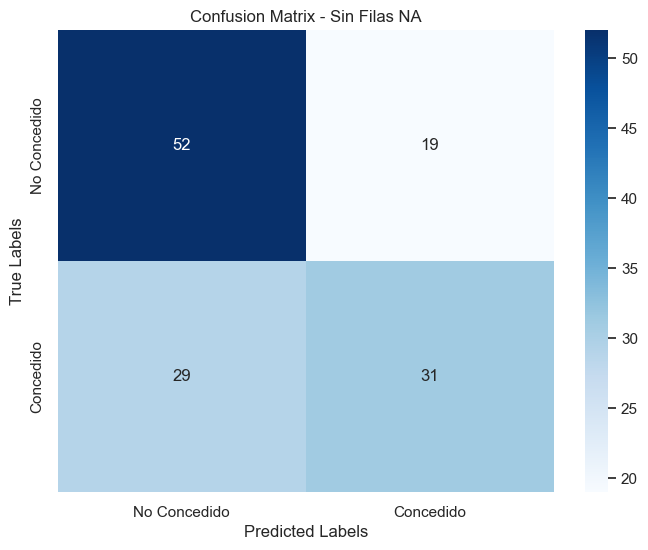

Reporte de Clasificación en conjunto de prueba sin NA:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        71
           1       0.62      0.52      0.56        60

    accuracy                           0.63       131
   macro avg       0.63      0.62      0.62       131
weighted avg       0.63      0.63      0.63       131



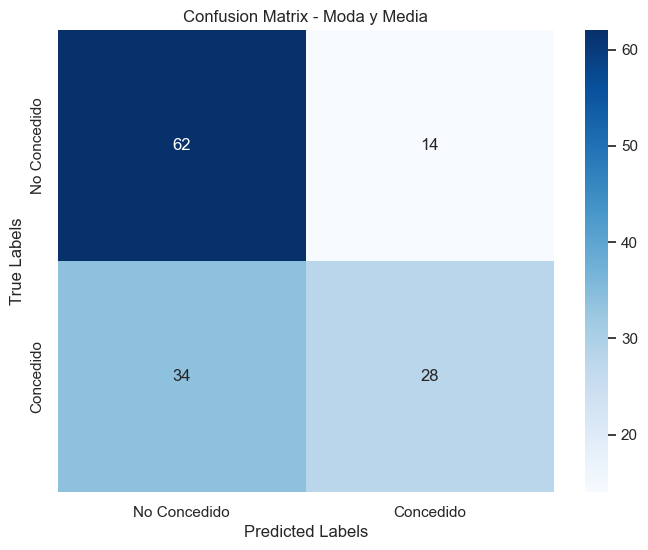

Reporte de Clasificación en conjunto de prueba con media y moda:
              precision    recall  f1-score   support

           0       0.65      0.82      0.72        76
           1       0.67      0.45      0.54        62

    accuracy                           0.65       138
   macro avg       0.66      0.63      0.63       138
weighted avg       0.66      0.65      0.64       138



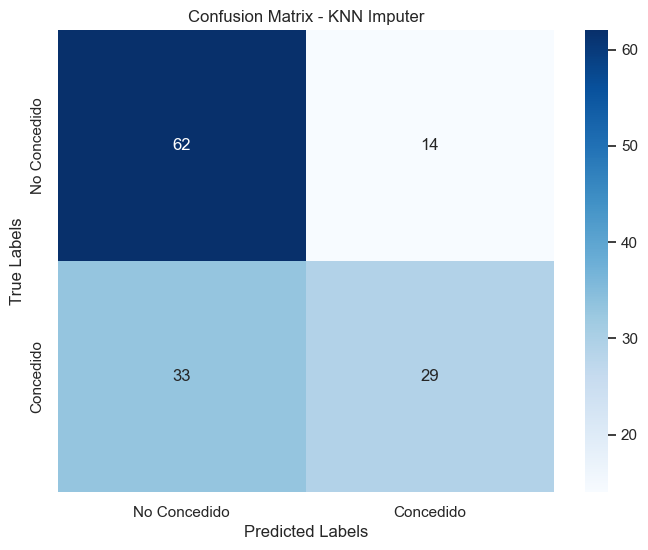

Reporte de Clasificación en conjunto de prueba con KNN imputer:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73        76
           1       0.67      0.47      0.55        62

    accuracy                           0.66       138
   macro avg       0.66      0.64      0.64       138
weighted avg       0.66      0.66      0.65       138



In [65]:
# Cargamos los modelos KNN
modelo_knn_na = joblib.load(ruta_modelos_knn + 'grid_search_knn_sin_filas_na.pkl')
modelo_knn_mm = joblib.load(ruta_modelos_knn + 'grid_search_knn_moda_media.pkl')
modelo_knn_knn = joblib.load(ruta_modelos_knn + 'grid_search_knn_knn_imputer.pkl')

# Obtenemos los mejores modelos
best_model_na = modelo_knn_na.best_estimator_
best_model_mm = modelo_knn_mm.best_estimator_
best_model_knn = modelo_knn_knn.best_estimator_

# Aseguramos que el label encoder esté entrenado
if not hasattr(label_encoder, 'classes_'):
    label_encoder.fit(y_train_sin_na)

# Predicciones
y_pred_na = best_model_na.predict(X_test_sin_na)
y_pred_mm = best_model_mm.predict(X_test)
y_pred_knn = best_model_knn.predict(X_test)

# Evaluaciones para el modelo sin filas NA
report_na = classification_report(label_encoder.transform(y_test_sin_na), y_pred_na, output_dict=True)
cm = confusion_matrix(label_encoder.transform(y_test_sin_na), y_pred_na)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Sin Filas NA')
plt.show()

print("Reporte de Clasificación en conjunto de prueba sin NA:")
print(classification_report(label_encoder.transform(y_test_sin_na), y_pred_na))

# Evaluaciones para el modelo con moda y media
report_mm = classification_report(label_encoder.transform(y_test), y_pred_mm, output_dict=True)
cm = confusion_matrix(label_encoder.transform(y_test), y_pred_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Moda y Media')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con media y moda:")
print(classification_report(label_encoder.transform(y_test), y_pred_mm))

# Evaluaciones para el modelo con KNN Imputer
report_knn = classification_report(label_encoder.transform(y_test), y_pred_knn, output_dict=True)
cm = confusion_matrix(label_encoder.transform(y_test), y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - KNN Imputer')
plt.show()

print("Reporte de Clasificación en conjunto de prueba con KNN imputer:")
print(classification_report(label_encoder.transform(y_test), y_pred_knn))



Para tener una información más compacta vamos a junta todas las métricas obtenidas en los modelos en una tabla para poder compararlas de una manera más sencilla.



| Modelo                      | Precision | Recall | F1-Score | Accuracy |
|-----------------------------|-----------|--------|----------|----------|
| AdaBoost sin NA             | 0.83      | 0.9    | 0.86     | 0.87     |
| AdaBoost MM                 | 0.82      | 0.87   | 0.84     | 0.86     |
| AdaBoost KNN                | 0.82      | 0.87   | 0.84     | 0.86     |
| Random Forest sin NA        | 0.86      | 0.85   | 0.86     | 0.87     |
| Random Forest MM            | 0.91      | 0.81   | 0.85     | 0.88     |
| Random Forest KNN           | 0.91      | 0.77   | 0.83     | 0.86     |
| Stacking sin NA             | 0.89      | 0.83   | 0.86     | 0.88     |
| Stacking MM                 | 0.89      | 0.79   | 0.84     | 0.86     |
| Stacking KNN                | 0.89      | 0.77   | 0.83     | 0.86     |
| Árbol de Decisión sin NA    | 0.83      | 0.82   | 0.82     | 0.84     |
| Árbol de Decisión MM        | 0.86      | 0.81   | 0.83     | 0.86     |
| Árbol de Decisión KNN       | 0.86      | 0.81   | 0.83     | 0.86     |
| KNN sin NA                  | 0.62      | 0.52   | 0.56     | 0.63     |
| KNN MM                      | 0.67      | 0.45   | 0.54     | 0.65     |
| KNN KNN                     | 0.67      | 0.47   | 0.55     | 0.66     |



Como podemos observar en la tabla, dentro de los modelos AdaBoost el que mejor resultados da es el que usa el dataset sin valores nulos, sin embargo en el random forest el modelo sin NA y el modeloo MM están muy parejos, en cambio el modelo KNN es el que peor resultados da. En el caso del Stacking el modelo sin NA es el que mejor resultados da, en cambio en el árbol de decisión el modelo sin NA es el que peor resultados da comparado con las otras dos estrategias. En el caso de KNN podemos ver que los 3 modelos son relativamente parecidos pero realmente malos. Son los peores modelos de todos los que hemos probado.

## ¿Qué modelo es el mejor?

Esto depende de lo que el banco considere más importante. Si el banco quiere minimizar los **Falsos Positivos** (concede un préstamo a un cliente que no va a poder devolverlo), entonces debería elegir el modelo con la mayor `Precision`. Si el banco quiere minimizar los **Falsos Negativos** (no concede un préstamo a un cliente que sí podría devolverlo), entonces debería elegir el modelo con el mayor `Recall`.

### Priorizar la precisión de `SI` (evitar pérdidas al banco por impagos):

**Mejor Modelo: `Random Forest MM`**

**Razón:**  
El modelo tiene una **precisión de 0'91 en `SI`**, lo que indica que un alto porcentaje de las personas a las que se les concede crédito son solventes. Esto reduce la posibilidad de que el banco otorgue créditos a personas que no van a poder pagarlos.  
El **recall en `SI` es 0.81**, lo cual es razonablemente alto, asegurando que no se pierdan demasiados buenos clientes.
En cambio el modelo `Random Forest KNN` tiene un recall de `0.77` y la misma precisión que el modelo `Random Forest MM`. Al tener un f1-score más bajo que el modelo `Random Forest MM` no lo consideramos el mejor modelo.




### Priorizar el recall de `SI` (evitar rechazar a demasiados buenos clientes):

**Mejor Modelo: `AdaBoost SIN NA`**

**Razón:**  
Este modelo tiene un **recall de 0.90 en `SI`**, lo que significa que es capaz de encontrar la mayoría de los clientes solventes, reduciendo el riesgo de rechazar clientes válidos.  
La **precisión en `SI` es 0.83**, lo que sigue siendo razonable para evitar demasiados falsos positivos, es decir, rechazar a clientes que podrían ser buenos.

Como podemos observar el peor modelo de todos por diferencia es el modelo de KNN. Los demás están todos muy parejos en cuanto a las métricas obtenidas. Por lo tanto, si el banco quiere priorizar la precisión de `SI` debería elegir el modelo de Stacking y si el banco quiere priorizar el recall de `SI` debería elegir el modelo de AdaBoost.

## Conclusiones finales

Como se mencionó al inicio del notebook, detectamos un **5.4%** de instancias con valores nulos en un conjunto de datos compuesto por 694 instancias. En un primer momento, podría haber parecido que lo más adecuado sería eliminar las filas con valores nulos. Sin embargo, decidimos evaluar cómo distintas estrategias para tratar los valores nulos afectaban al rendimiento de los modelos. Tras probar diversas opciones, observamos que el manejo de los valores nulos ha tenido cierto impacto en los resultados. Mejorando unos modelos y empeorando otros.

Dado que casi todos los modelos que hemos utilizado se basan en el mismo tipo de estimador (árbol de decisión), los resultados obtenidos en cuanto a las métricas fueron muy similares. El siguiente paso sería probar modelos que utilicen estimadores diferentes para ver si obtenemos mejores resultados o, por el contrario, si el rendimiento empeora, como sucedió con el modelo de **KNN**.
